
Project 4: Generative Adversarial Networks
======
In this project, you are expected to fill in the missing parts of a PyTorch implementation of the Deep Convolutional Generative Adversarial Network (DCGAN) [1] and test its performance on several datasets.<br>
Please **read the instructions carefully**. We provide reference outputs for most tasks and we will judge your solution based on your code as well as on the quality of your output and similarity to our results.

We will be using datasets with small images for this project, because high-resolution GANs take notoriously long to train.

**References:**

[1] [Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[2] [MNIST dataset.](http://yann.lecun.com/exdb/mnist/)

[3] [FashionMNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)

[4] [UTKFace dataset.](https://susanqq.github.io/UTKFace/)

## Assignment 4A: DCGAN

### Verify your PyTorch installation

In [1]:
import torch
import torchvision

# Print Basic Information
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print("Torchvision", torchvision.__version__)
print('Device:', torch.device('cuda:0'))

Torch 1.2.0 CUDA 10.0.130
Torchvision 0.4.0a0
Device: cuda:0


In [2]:
#import statements
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torchsummary import summary
import numpy as np

### 1) Load and prepare the dataset (5 points)

Pick either _MNIST_ [2] or _FashionMNIST_ [3] as your dataset for this assignment. Both datasets contain grayscale images with a natural resolution of $28\times28$ pixels, have 10 classes and can be imported from `torchvision.datasets`.<br>
The color channels in the _MNIST_ as well as in _FashionMNIST_ dataset are stored inverted, ie with white content on a black background. This is because, per default, convolution layers in the network add zero-padding to the image, hence a black background works more naturally and yields better results during training.
We do, however, want to show our results with **black content** on a **white background**. To that end, **add appropriate functionality** in the plotting/visualization functions throughout this notebook to invert and clamp the image values (see below visualization).

<img src="img/mnist_example.JPG" width="800">
<img src="img/fashion_mnist_example.JPG" width="800">


Implement the data loading, create the necessary **data transforms** such that your training images have $32\times32$ pixels, and have a value range between $[-1, 1]$:

Consider whether you can implement some **data augmentation**, and if possible, do so.

In [3]:
#######################################################################################################
# TODO 1: Load dataset. Implement the necessary functions so your data has a resolution of 32x32 pixels
# and the values are normalized to a [-1, 1] range. 
# Consider whether you can implement some data augmentation, and if possible, do so.
#######################################################################################################
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5],
                        [0.5])
    ])
train_dataset = datasets.FashionMNIST(root="data/", transform=transform, download=True)

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  60000
Image size: torch.Size([1, 32, 32])
value range: [ -1.0 - 0.9450980424880981 ]


#### Inspect the training data

**Visualize a few examples** from your training data.

In [4]:
def convertColors(image):
    '''
    image: torch.Tensor in range [-1, 1]
    --------
    return: torch.Tensor in range [0, 1] with inverted colors
    '''
    
    return (1.0 - image) * 0.5

In [78]:
def convertColors_(image):
    '''
    image: torch.Tensor in range [-1, 1]
    --------
    return: torch.Tensor in range [0, 1]
    '''
    
    return (1.0 + image) * 0.5

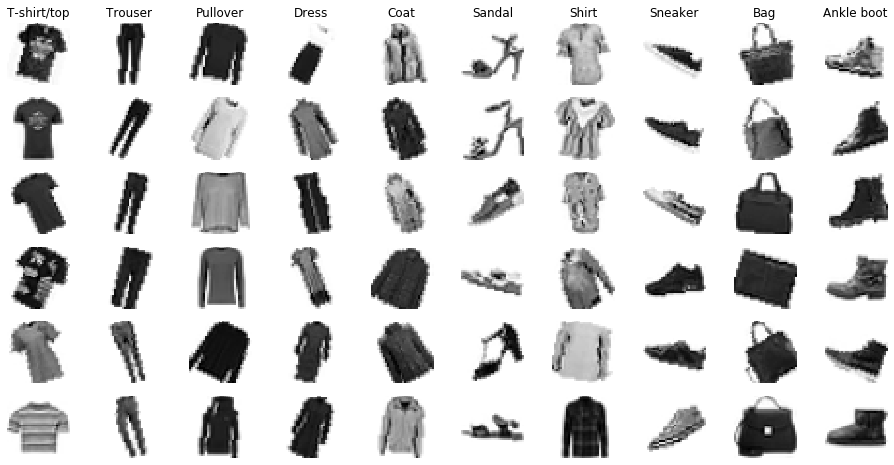

In [5]:
labels = train_dataset.classes
fig = plt.figure(figsize=(16, 8))
rows = 6

images = {}
for label in range(len(labels)):
    images[label] = []

#find some images for each label    
for x in range(1000):
    rand = np.random.randint(len(train_dataset))
    label = train_dataset[rand][1]
    if len(images[label]) > rows:
        continue
    images[label].append(train_dataset[rand][0][0,:,:])


for label in range(len(labels)):
    for row in range(rows):
        image = convertColors(images[label][row])
        fig.add_subplot(rows, len(labels), row * len(labels) + label + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        if row == 0:
            plt.title(labels[label])
plt.show()

### 2) Choose appropriate hyperparameters for the training (4 points)

In [18]:
#######################################################################################################
# TODO 2: choose sensible training parameters for DCGAN training. 
# Start with few epochs while you design the network, and increase once you think you have a good setup.
# Since GANs train slowly, you may have to use at quite a few epochs to see good results.
#######################################################################################################
batch_size = 256
lr = 0.0002
num_epochs = 48

### 3) Implement the generator network (8 points)
The expected output of this GAN should look like this (or better):

<img src="img/DCGAN_MNIST.png" align='left' width="355">
<img src="img/DCGAN_fashionMNIST.png" align='left' width="355">

Implement the **DCGAN Generator** and **Discriminator** networks for an output size of $32\times32$ pixels according to the given network diagrams. 

<img src="img/DCGAN_Generator.png" align='left' width="800">

Create a function to initialize the weights for `nn.Conv2d` and `nn.ConvTranspose2d` layers with a custom distribution. To that end, complete the function `normal_init`, which initialized the weights of the given pytorch layer with a Normal distribution centered around $mean$ and a standard deviation $std$.

##### Hint: 
`summary` from the `torchsummary` package is a very helpful tool to inspect the layers in your network. Use it like so:

```
M = MyNetwork()
M.cuda()
summary(M, input_size=myExpectedInputSize)
```

In [7]:
#######################################################################################################
# TODO 3a: implement a function that initializes the layer's weights with mean and standard deviation.
#######################################################################################################

def normal_init(tensor, mean, std):
    nn.init._no_grad_normal_(tensor, mean, std)

In [8]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []    
    conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, 
                                        kernel_size, stride, padding, bias=False)
    layers.append(conv_transpose)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [9]:
# # TODO 3b: implement the generator network for a DCGAN with output size 32x32px
#######################################################################################################
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 512)
        self.tr_conv1 = deconv(512, 512, 4, stride=1, padding=0)
        self.tr_conv2 = deconv(512, 256, 4)
        self.tr_conv3 = deconv(256, 128, 4)
        self.tr_conv4 = deconv(128, 1, 4, batch_norm=False)
        

    # forward method
    def forward(self, inp):
        batch_size = inp.size()[0]
        x = self.fc(inp)
        x = x.view(batch_size, 512, 1, 1)
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        x = F.relu(self.tr_conv3(x))
        x = torch.tanh(self.tr_conv4(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for (name, param) in self.named_parameters():
            normal_init(param.data, mean, std)           

### 4) Implement the discriminator network (8 points)
<img src="img/DCGAN_Discriminator.png" align='left' width="800">

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

In [11]:
#######################################################################################################
# TODO 3c: implement the discriminator network for a DCGAN with input size 32x32px
#######################################################################################################
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(1, 128, 4, batch_norm=False)
        self.conv2 = conv(128, 256, 4)
        self.conv3 = conv(256, 512, 4)
        self.conv4 = conv(512, 512, 4, stride=1, padding=0)
        self.fc = nn.Linear(512, 1)
        self.LRelu = nn.LeakyReLU(0.2)        

    # forward method
    def forward(self, input):
        batch_size = input.size()[0]
        x = self.LRelu(self.conv1(input))
        x = self.LRelu(self.conv2(x))
        x = self.LRelu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        x = x.view(batch_size, -1)
        x = torch.sigmoid(self.fc(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for (_, param) in self.named_parameters():
            normal_init(param.data, mean, std)          

In [79]:
grid_size = 6

#######################################################################################################
# TODO 4: generate a fixed noise vector to repeatedly evaluate the output of the generator 
# with the same noise vector as training progresses
#######################################################################################################
fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(1, 100))).float().cuda()

# output generated samples from the current state of the generator network
def show_result(num_epoch, show=False, save=False, grid_size=6, path = 'result.png', useFixed=False, inverted=True):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z).cpu()
        else:
            # TODO generate a new random noise vector
            z = torch.from_numpy(np.random.uniform(-1, 1, size=(1, 100))).float().cuda()
            fake = G(z).cpu()
        if inverted:
            fake = convertColors(fake)
        else:
            fake = convertColors_(fake)
        fig, ax = plt.subplots(figsize=(8, 8))
        
        image = utils.make_grid(fake.data, grid_size, 1)
        
        plt.imshow(np.transpose(image, (1, 2, 0)))    
        ax.axis('off')
        plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### 5) Training Setup (5 points) and Training Loop (10 points)

Instantiate a Generator and a Discriminator network, move networks to GPU and initialize the weights of their convolutional layers with $\mu=0$ and $\sigma=0.02$.

Create an ADAM optimizer for the generator as well as the discriminator with your chosen learning rate. Use $\beta_1=0.5$ and $\beta_2=0.999$ as described in Section 4 of the paper.

In the training loop, evaluate the output of the generator network on a random latent vector of length 100. Then, evaluate the performance of the discriminator on the generated images as well as the real image minibatch. Assign the real results the label $1$ (`torch.ones`) and the fake results the label $0$ (`torch.zeros`), then calculate the losses for each of these steps using Binary Cross Entropy loss.
        

#### Hint:
If you would like to load a stored model for additional training or for evaluation, you can do it the following way:
```
M = MyNetwork() #instantiate the network
checkpoint = torch.load("path_to_stored_network.pkl")
M.load_state_dict(checkpoint)
M.eval()
``` 

*If your model fails to train properly, include the failure cases into your report, explain what you think went wrong, and try again!*

Training ...
Epoch [1 / 48] G loss: 0.6931999325752258 D loss: 1.3861453533172607


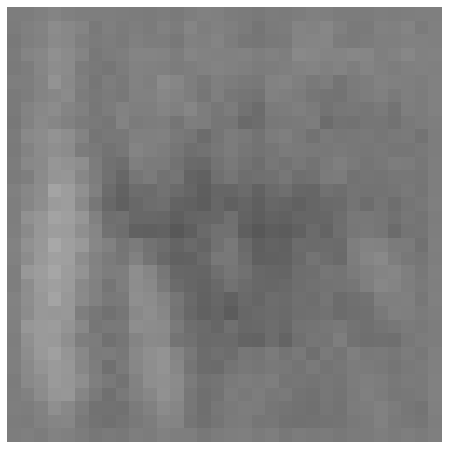

Epoch [2 / 48] G loss: 0.6936429142951965 D loss: 1.3849809169769287


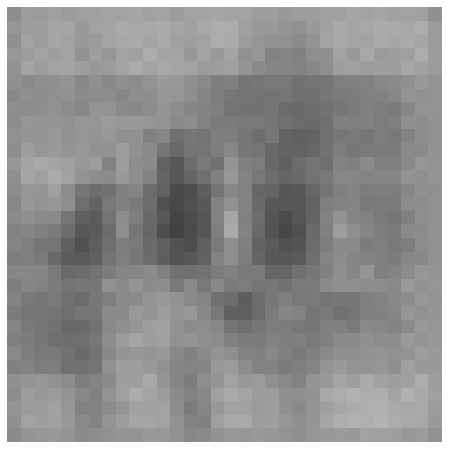

Epoch [3 / 48] G loss: 0.6975974440574646 D loss: 1.379647135734558


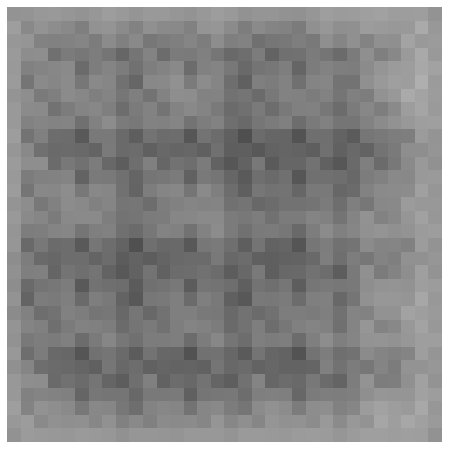

Epoch [4 / 48] G loss: 0.6959452629089355 D loss: 1.3576700687408447


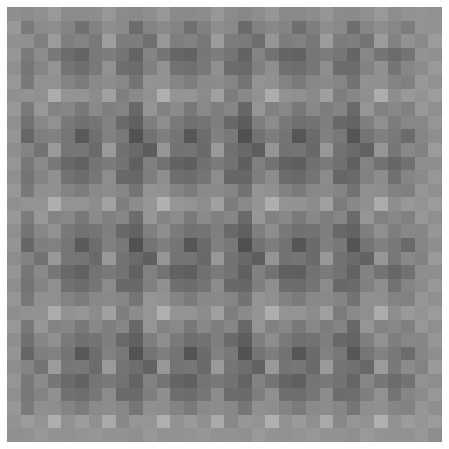

Epoch [5 / 48] G loss: 0.7320751547813416 D loss: 1.3074214458465576


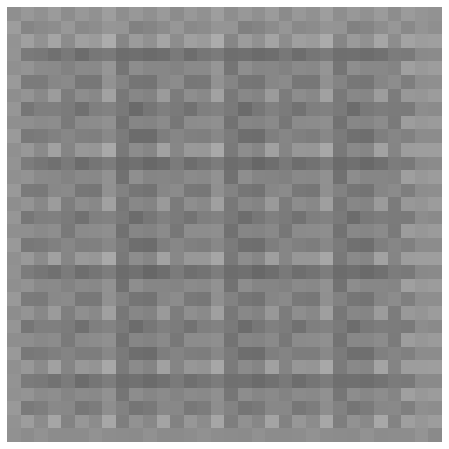

Epoch [6 / 48] G loss: 0.7921801209449768 D loss: 1.198527455329895


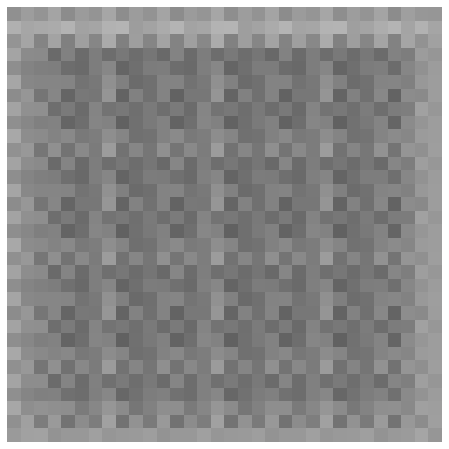

Epoch [7 / 48] G loss: 0.9011371731758118 D loss: 1.055309772491455


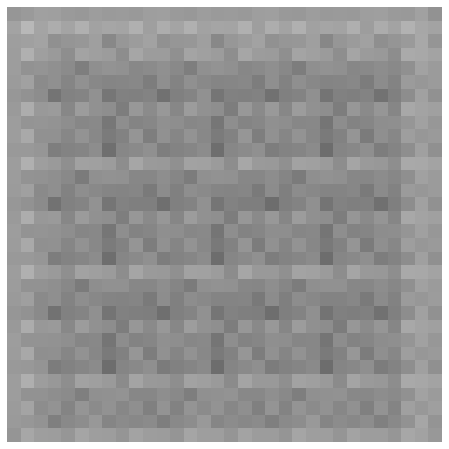

Epoch [8 / 48] G loss: 1.0458966493606567 D loss: 0.8703186511993408


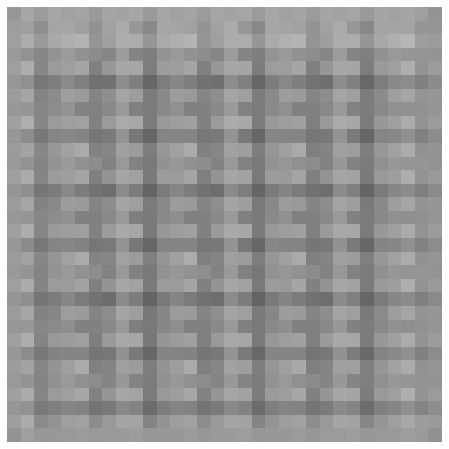

Epoch [9 / 48] G loss: 1.2562333345413208 D loss: 0.6726935505867004


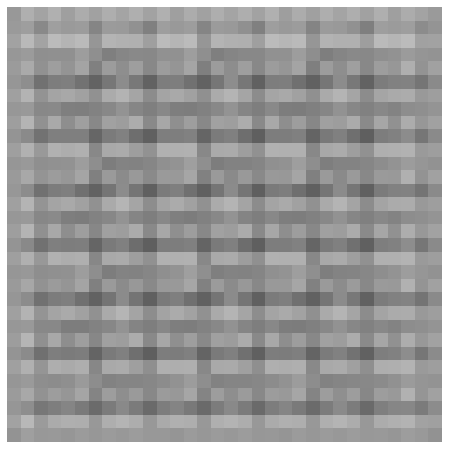

Epoch [10 / 48] G loss: 1.509682536125183 D loss: 0.5082789659500122


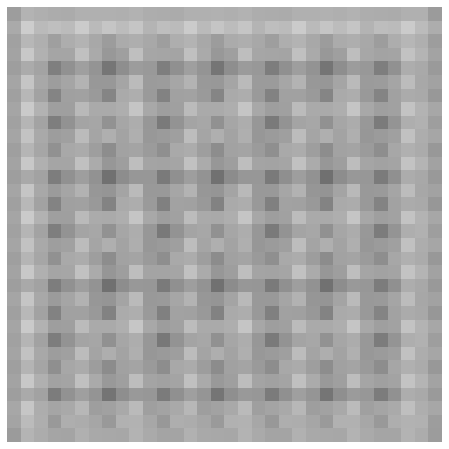

Epoch [11 / 48] G loss: 1.8343013525009155 D loss: 0.3580939471721649


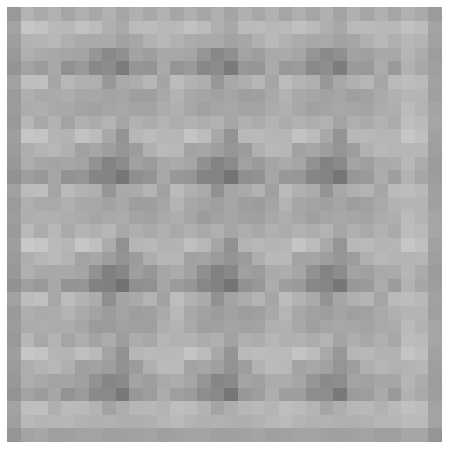

Epoch [12 / 48] G loss: 2.010741949081421 D loss: 0.2980542778968811


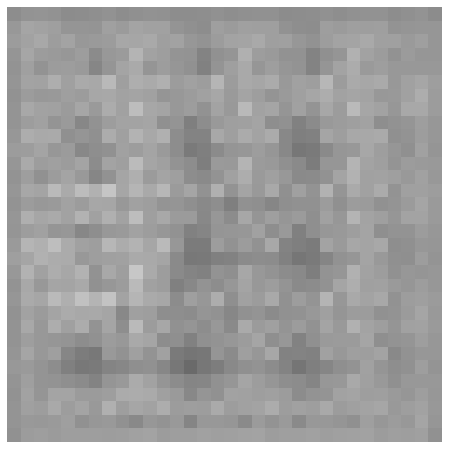

Epoch [13 / 48] G loss: 1.1186442375183105 D loss: 0.9778863191604614


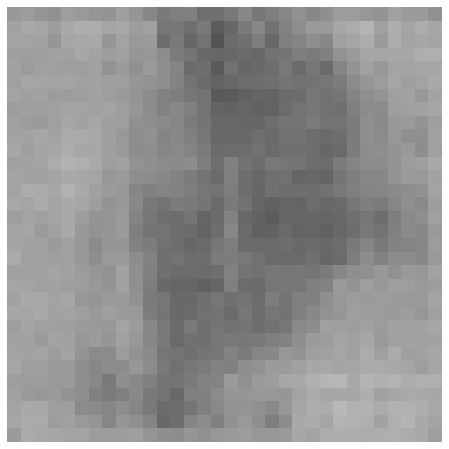

Epoch [14 / 48] G loss: 1.2425819635391235 D loss: 0.8747894763946533


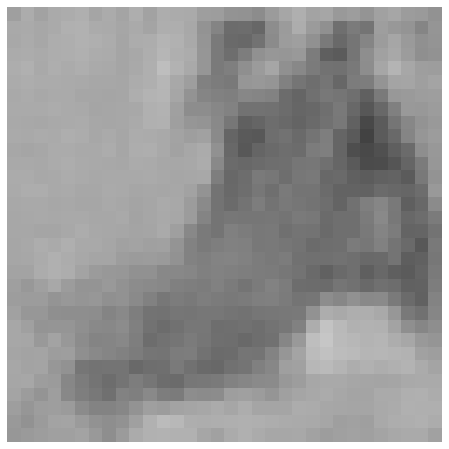

Epoch [15 / 48] G loss: 0.9828090667724609 D loss: 1.097076654434204


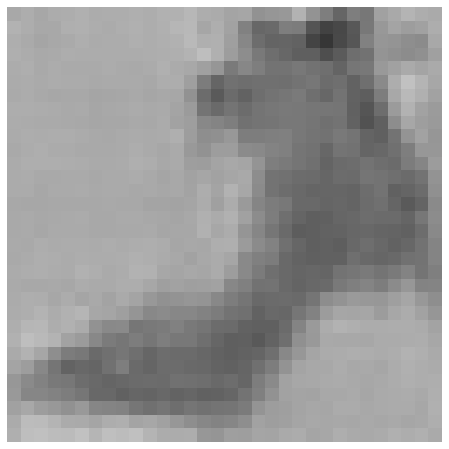

Epoch [16 / 48] G loss: 1.3437156677246094 D loss: 1.0902118682861328


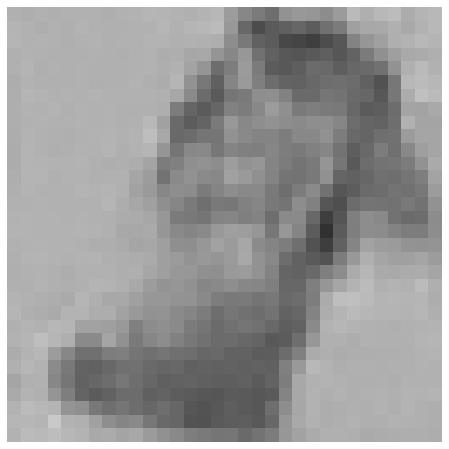

Epoch [17 / 48] G loss: 0.8647899031639099 D loss: 1.0801680088043213


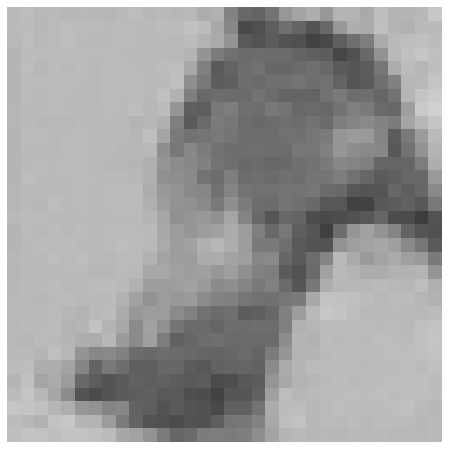

Epoch [18 / 48] G loss: 1.062709927558899 D loss: 1.0635461807250977


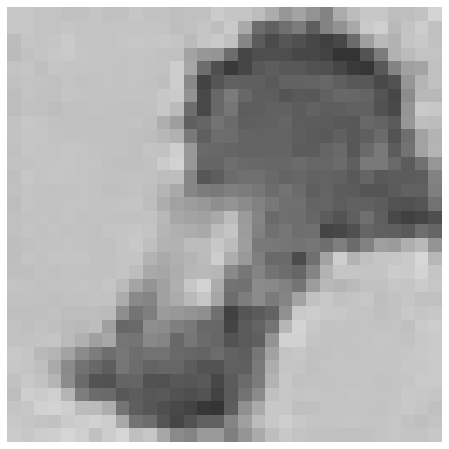

Epoch [19 / 48] G loss: 1.0390558242797852 D loss: 1.1077322959899902


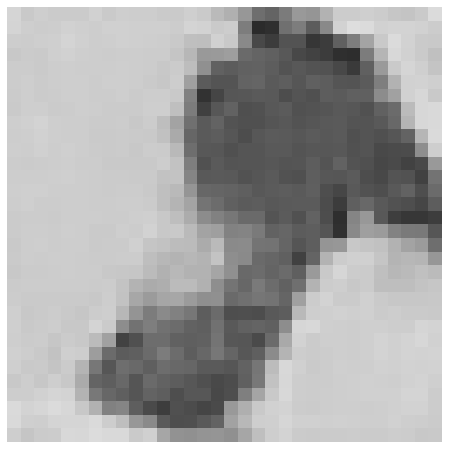

Epoch [20 / 48] G loss: 1.0154962539672852 D loss: 1.0560128688812256


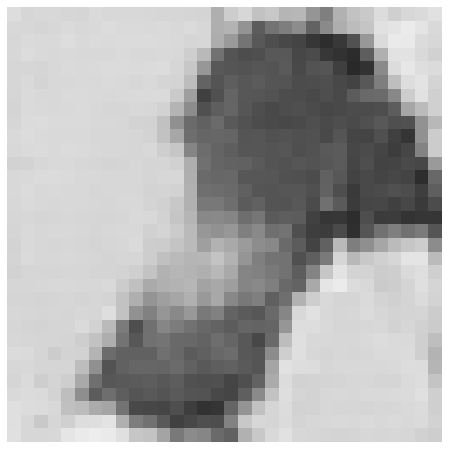

Epoch [21 / 48] G loss: 0.9267867207527161 D loss: 1.174060583114624


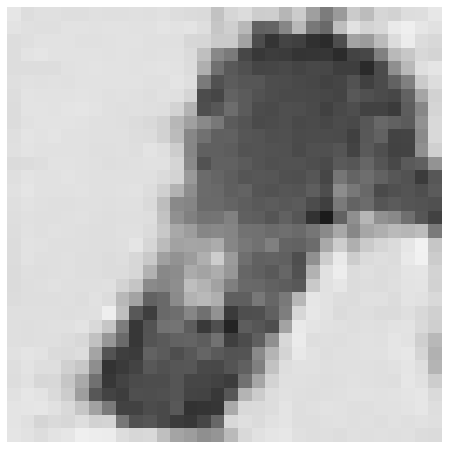

Epoch [22 / 48] G loss: 1.0387684106826782 D loss: 1.1807050704956055


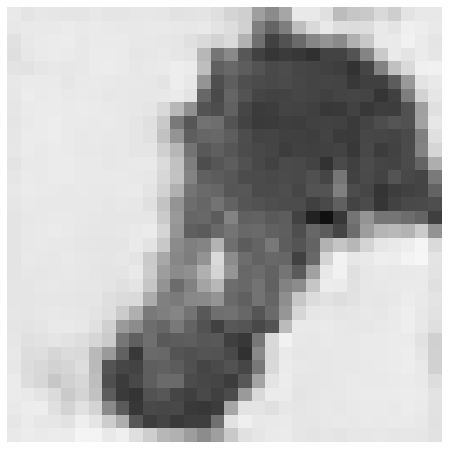

Epoch [23 / 48] G loss: 1.0572632551193237 D loss: 1.145599603652954


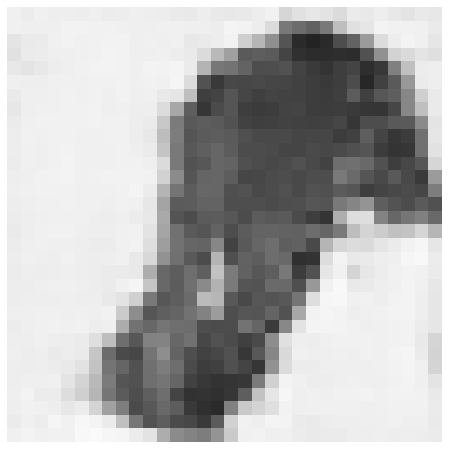

Epoch [24 / 48] G loss: 0.9635701775550842 D loss: 1.072706937789917


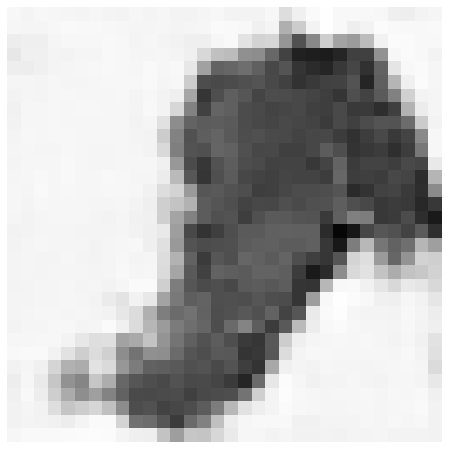

Epoch [25 / 48] G loss: 1.1988681554794312 D loss: 1.2694438695907593


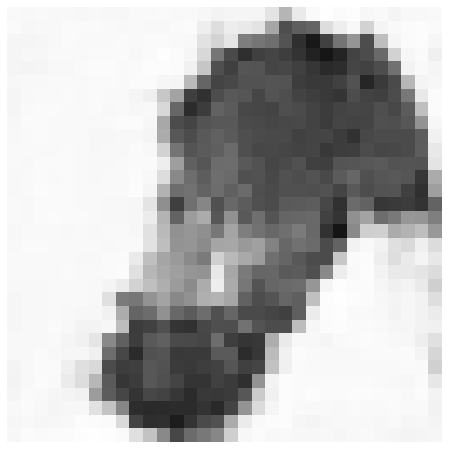

Epoch [26 / 48] G loss: 0.9731526374816895 D loss: 1.1449127197265625


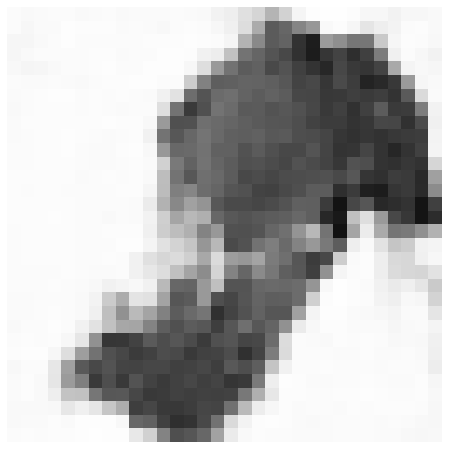

Epoch [27 / 48] G loss: 0.8473652005195618 D loss: 1.1568788290023804


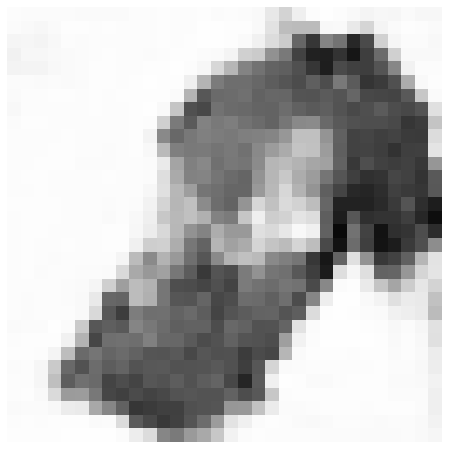

Epoch [28 / 48] G loss: 0.8860215544700623 D loss: 1.0921814441680908


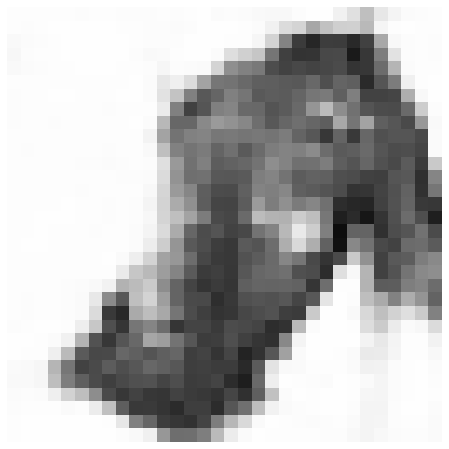

Epoch [29 / 48] G loss: 1.34359610080719 D loss: 1.0754408836364746


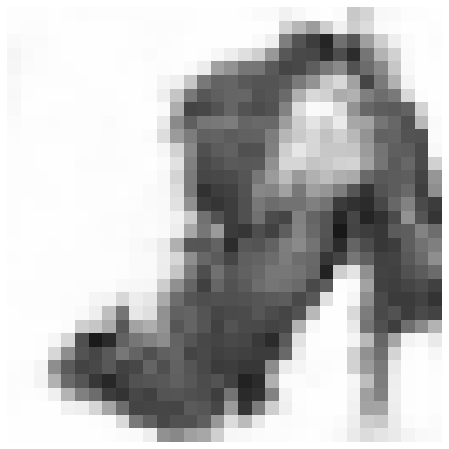

Epoch [30 / 48] G loss: 1.2764240503311157 D loss: 1.1170904636383057


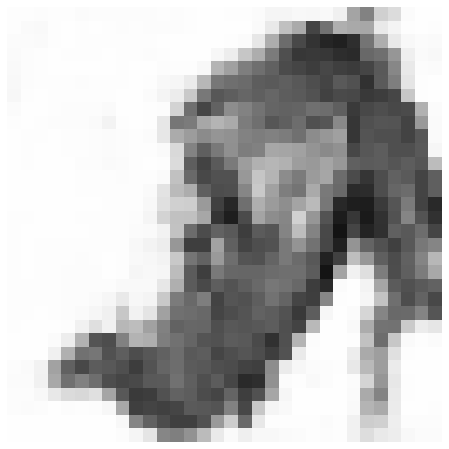

Epoch [31 / 48] G loss: 1.5792001485824585 D loss: 1.0776057243347168


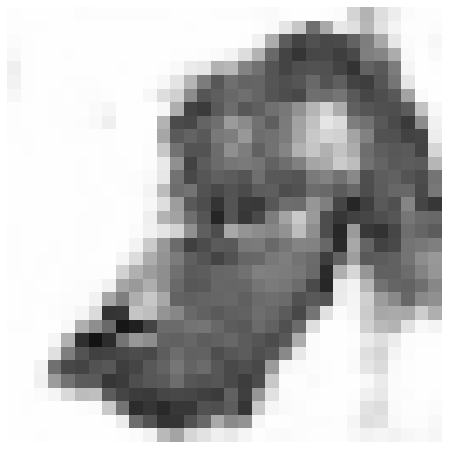

Epoch [32 / 48] G loss: 0.922821581363678 D loss: 0.923457145690918


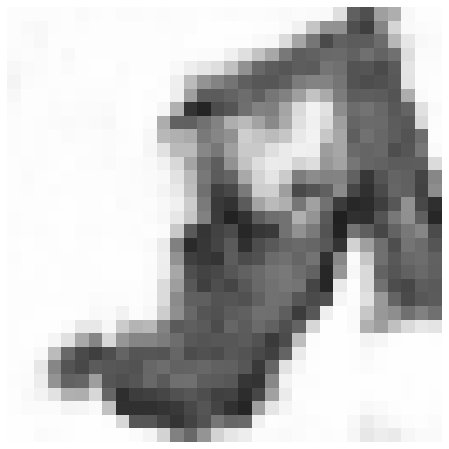

Epoch [33 / 48] G loss: 1.286395788192749 D loss: 0.8313997387886047


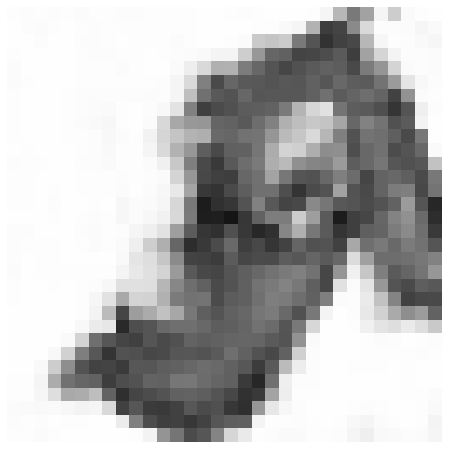

Epoch [34 / 48] G loss: 1.6101813316345215 D loss: 0.6386643648147583


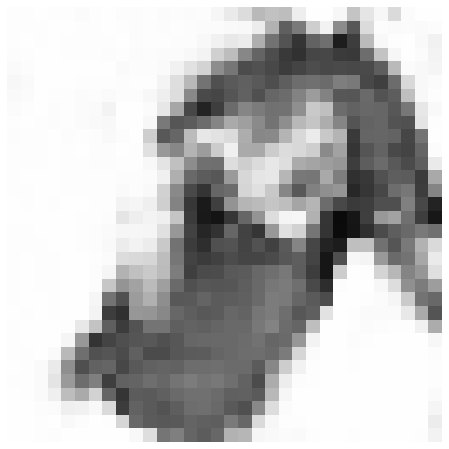

Epoch [35 / 48] G loss: 2.1066970825195312 D loss: 0.8007588982582092


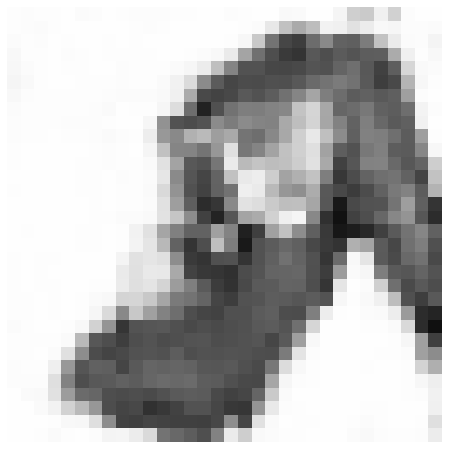

Epoch [36 / 48] G loss: 1.4599331617355347 D loss: 0.6493570804595947


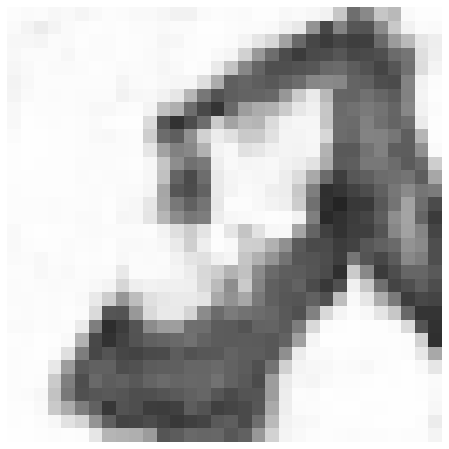

Epoch [37 / 48] G loss: 1.8188835382461548 D loss: 0.4890308976173401


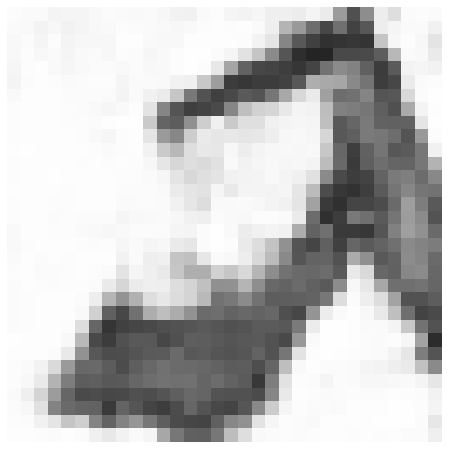

Epoch [38 / 48] G loss: 1.8531756401062012 D loss: 0.3938402533531189


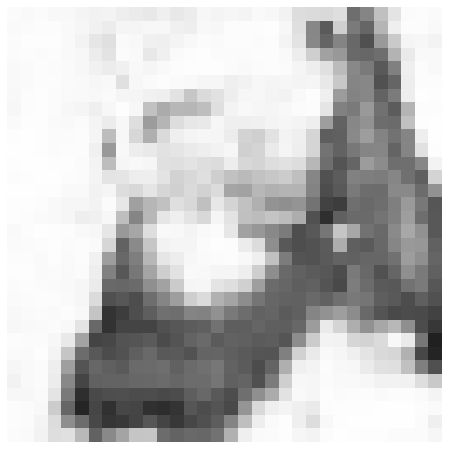

Epoch [39 / 48] G loss: 2.4156548976898193 D loss: 0.3322441577911377


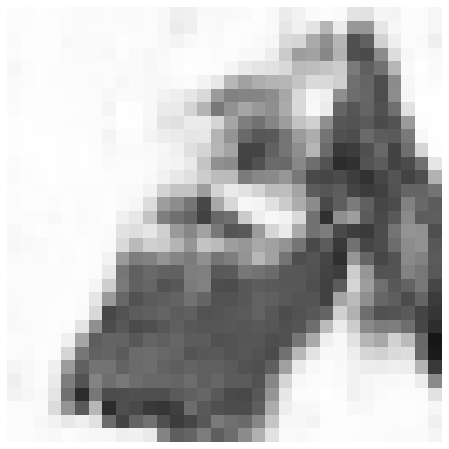

Epoch [40 / 48] G loss: 2.360046625137329 D loss: 0.226742222905159


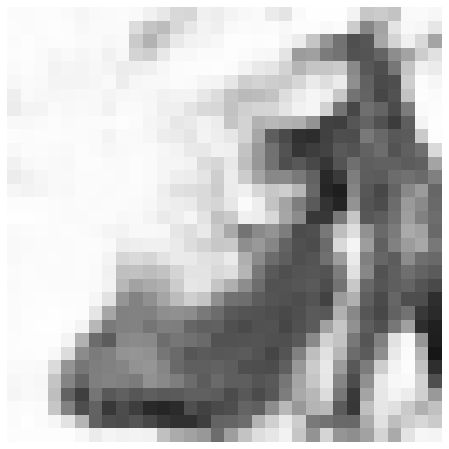

Epoch [41 / 48] G loss: 3.246962547302246 D loss: 0.11428675055503845


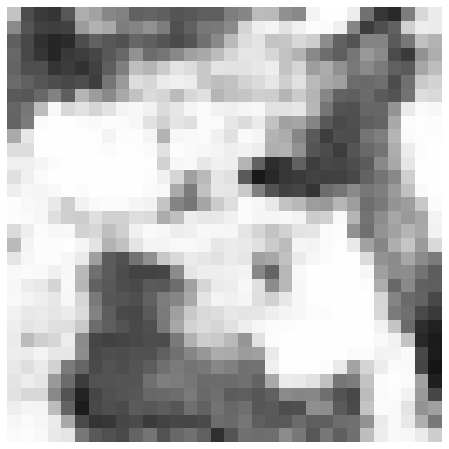

Epoch [42 / 48] G loss: 2.8572065830230713 D loss: 0.6491266489028931


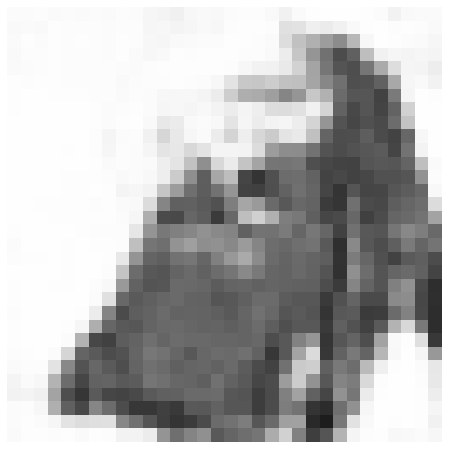

Epoch [43 / 48] G loss: 2.426624298095703 D loss: 0.34371820092201233


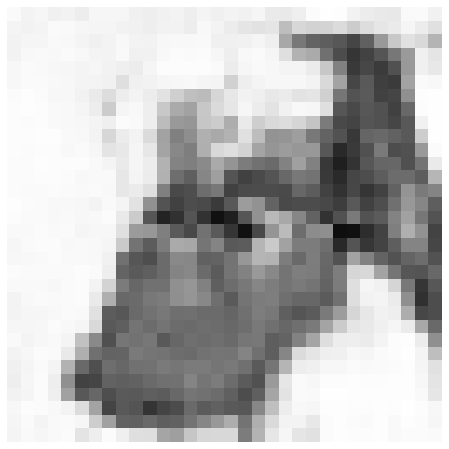

Epoch [44 / 48] G loss: 2.3415486812591553 D loss: 0.47795289754867554


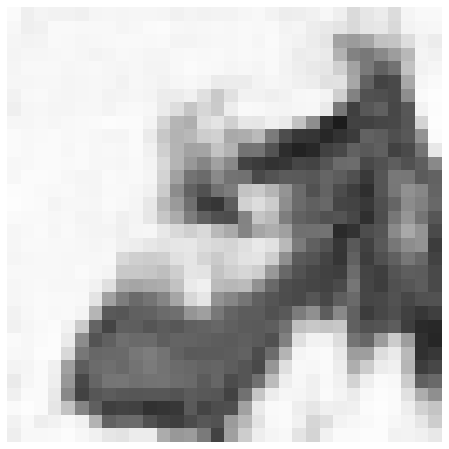

Epoch [45 / 48] G loss: 2.8317883014678955 D loss: 0.15822379291057587


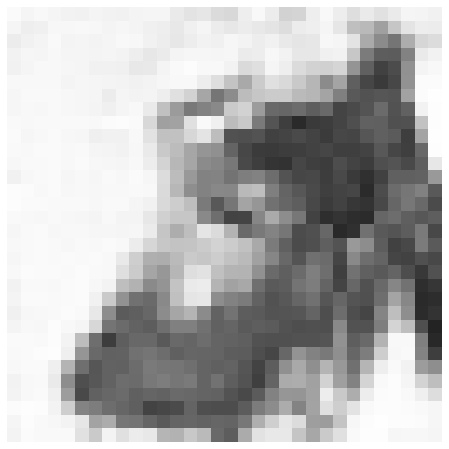

Epoch [46 / 48] G loss: 3.397761344909668 D loss: 0.10776562988758087


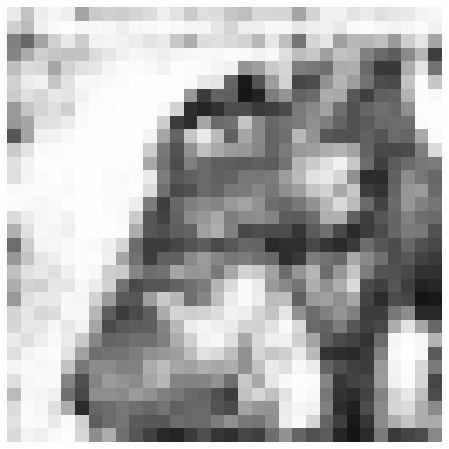

Epoch [47 / 48] G loss: 3.148512601852417 D loss: 0.13695378601551056


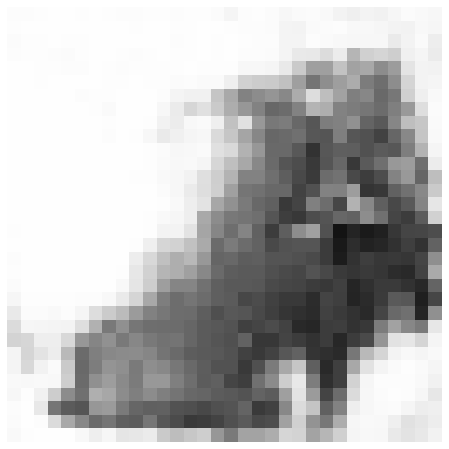

Epoch [48 / 48] G loss: 3.3482859134674072 D loss: 0.11048555374145508


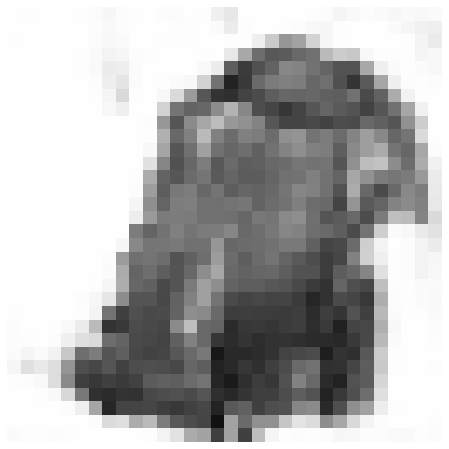

Avg per epoch time: 54.06 sec, total 48 epochs time: 43.35 min
Training finished!
...saving training results


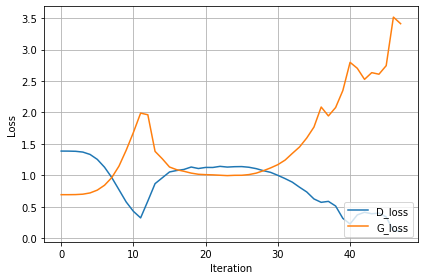

In [20]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dset_name = 'myDataset' #pick a meaningful name
result_dir = '{}_DCGAN'.format(dset_name)

device = torch.device("cuda:0")


#######################################################################################################
# TODO 5a: Fill code for training setup
#######################################################################################################

# define networks
G = Generator()
G.weight_init(0, 0.02)
G = G.cuda()
D = Discriminator()
D.weight_init(0, 0.02)
D = D.cuda()
# print(G, D)


# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[0.5, 0.999])
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[0.5, 0.999]) 
loss_function = nn.BCELoss()

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(result_dir+'/Random'):
    os.mkdir(result_dir+'/Random')
if not os.path.isdir(result_dir+'/Fixed'):
    os.mkdir(result_dir+'/Fixed')

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    for real, _ in data_loader:
        real = real.to(device)
        batch_size = real.size(0)
        
        #######################################################################################################
        # TODO 5b: Fill code for training loop
        #######################################################################################################
        
        # generate random latent vector z and real and fake labels 
    
        z = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 100))).float().cuda()
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()
        
        # generate fakes    

        fake_images = G(z)
        
        # evaluate fakes
        
        fake_evals = D(fake_images)

        # evaluate real minibatch
         
        real_evals = D(real)
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = loss_function(fake_evals, fake_labels) + loss_function(real_evals, real_labels)

        # train discriminator D step
        D.zero_grad()
        G.zero_grad()
        D_train_loss.backward(retain_graph=True)
        D_optimizer.step()    
        
        # train generator to output an image that is classified as real
        
        z = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 100))).float().cuda()
        fake_images = G(z)
        fake_evals = D(fake_images)        
        G_train_loss = loss_function(fake_evals, real_labels)
        
        # train generator G step
        D.zero_grad()
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_result( epoch, save=True, path=result_dir + '/Random/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=False )
    show_result( epoch, save=True, show=True, path=result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)

end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot the loss curves    
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# Visualize the training progress as an animated GIF
images = []
for e in range(num_epochs):
    img_name = result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

<img src='myDataset_DCGAN/DCGAN_generation_animation.gif' width="512">

### 6) Explore the latent space of the generator (5 points)
We now want to **explore the expressiveness** of the Generator. Intuitively, a small change in values of the latent vector $z$ should result in a small change in the output image, and a linear interpolation between two latent vectors $z_1$ and $z_2$ should yield a reasonably smooth transition from one valid output image to another. Implement a function that creates a grid of latent vectors, where each row is an interpolation from the leftmost to the rightmost latent vector, with $n$ interpolation steps.

The expected output of this function should look like this (or better): 


<img src="img/latent_space_morph_MNIST.PNG" width="900">
<img src="img/latent_space_morph_FashionMNIST.png" width="900">

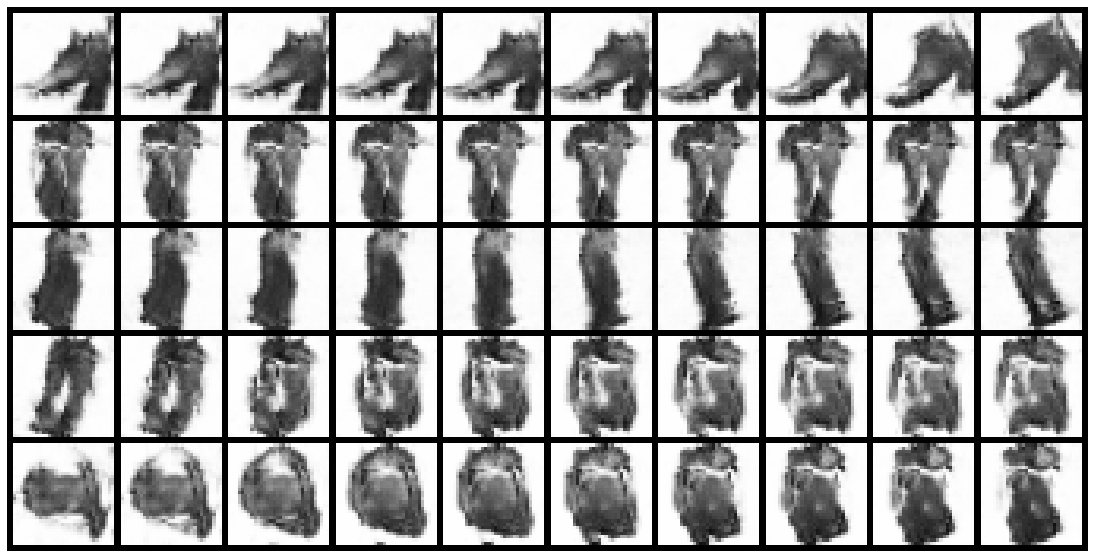

In [31]:
def generate_latent_interpolation(rows=5, interp_steps=10):
     with torch.no_grad():
        #######################################################################################################
        # TODO 6: for each row, create interpolation between leftmost and rightmost output image
        #######################################################################################################
        
        grid_images = torch.zeros(rows * interp_steps, 1, 32, 32)
        
        for row in range(rows):
            z_1 = torch.from_numpy(np.random.uniform(-1, 1, size=(1, 100))).float().cuda()
            z_2 = torch.from_numpy(np.random.uniform(-1, 1, size=(1, 100))).float().cuda()
            for i in range(interp_steps):
                z = z_1 + i * (z_2 - z_1) / interp_steps
                image = convertColors(G(z))
                grid_images[row * interp_steps + i] = image
        
        fig, ax = plt.subplots(figsize=(20, 10))
        grid = utils.make_grid(grid_images, interp_steps)
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        ax.axis('off')

generate_latent_interpolation()        

### 7) Modify the network to output $64\times64$ RGB images (10 points)

Download `UTK_face.tar.gz` from [Google Drive](https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE) and extract the images to your working directory in the folder `./data/UTKFace/train`. This dataset [4] contains approximately 24K cropped images of human faces of mixed age, gender and race.

Load these images and resize them to the dimensions you want to generate ($64\times64$ RGB images). Replicate and modify your Generator and Discriminator network architectures in order to output the appropriate image size and three color channels. You may want to consult the [original DCGAN paper](https://arxiv.org/abs/1511.06434) to check what their suggested architecture looks like. You should generate an output similar to this (or better):

<img src="img/DCGAN_faces.png" width="900">



You can either modify the code above, or copy the necessary code pieces, but **make sure you include all results** of different datasets in your final report or in this notebook.

In [55]:
class Generator_face(nn.Module):
    def __init__(self):
        super(Generator_face, self).__init__()
        self.fc = nn.Linear(100, 512)
        self.tr_conv1 = deconv(512, 512, 4, stride=1, padding=0)
        self.tr_conv2 = deconv(512, 256, 4)
        self.tr_conv3 = deconv(256, 128, 4)
        self.tr_conv4 = deconv(128, 64, 4)
        self.tr_conv5 = deconv(64, 3, 4, batch_norm=False)
        

    # forward method
    def forward(self, inp):
        batch_size = inp.size()[0]
        x = self.fc(inp)
        x = x.view(batch_size, 512, 1, 1)
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        x = F.relu(self.tr_conv3(x))
        x = F.relu(self.tr_conv4(x))
        x = torch.tanh(self.tr_conv5(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for (name, param) in self.named_parameters():
            normal_init(param.data, mean, std) 
            
class Discriminator_face(nn.Module):
    def __init__(self):
        super(Discriminator_face, self).__init__()
        self.conv1 = conv(3, 128, 4, batch_norm=False)
        self.conv2 = conv(128, 256, 4)
        self.conv3 = conv(256, 512, 4)
        self.conv4 = conv(512, 1024, 4)
        self.fc = nn.Linear(1024 * 16, 1)
        self.LRelu = nn.LeakyReLU(0.2)        

    # forward method
    def forward(self, input):
        batch_size = input.size()[0]
        x = self.LRelu(self.conv1(input))
        x = self.LRelu(self.conv2(x))
        x = self.LRelu(self.conv3(x))
        x = self.LRelu(self.conv4(x))
        x = x.view(batch_size, -1)
        x = torch.sigmoid(self.fc(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for (_, param) in self.named_parameters():
            normal_init(param.data, mean, std)

In [76]:
#######################################################################################################
# TODO 7: resize the images such that they have the shape of 3x64x64
#######################################################################################################
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])
train_dataset = torchvision.datasets.ImageFolder(
    root='./data/UTKFace',
    transform=transform
)

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  23708
Image size: torch.Size([3, 64, 64])
value range: [ 0.019607843831181526 - 0.9960784316062927 ]


Training ...


/home/gasanoe/anaconda3/envs/py3/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/gasanoe/anaconda3/envs/py3/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [1 / 28] G loss: 4.265529632568359 D loss: 1.2432966232299805


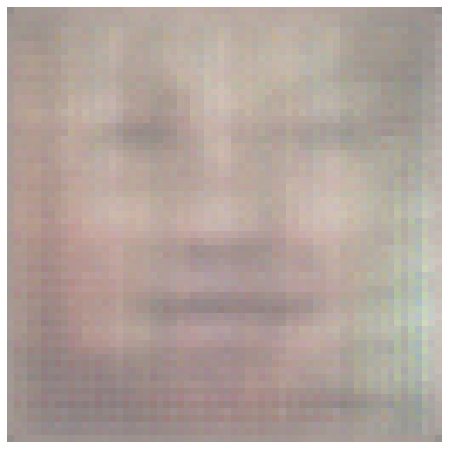

Epoch [2 / 28] G loss: 2.281599283218384 D loss: 0.5472339391708374


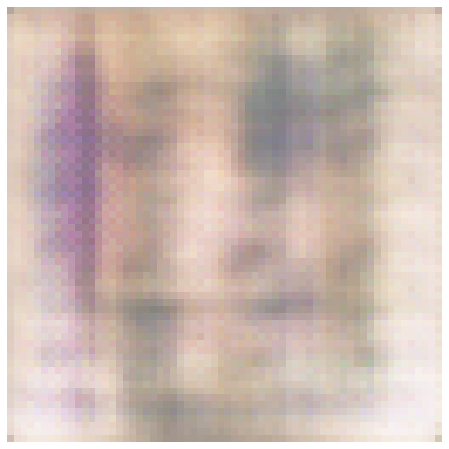

Epoch [3 / 28] G loss: 2.2350175380706787 D loss: 0.6991125345230103


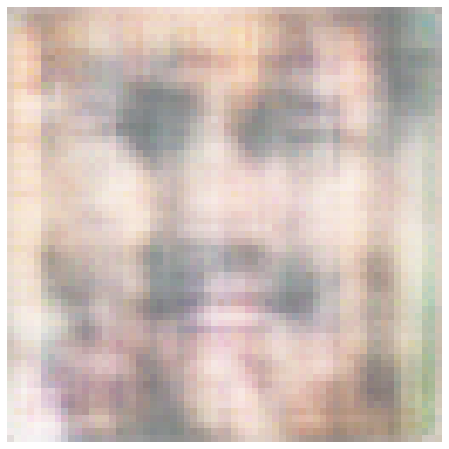

Epoch [4 / 28] G loss: 2.3816869258880615 D loss: 0.5681480169296265


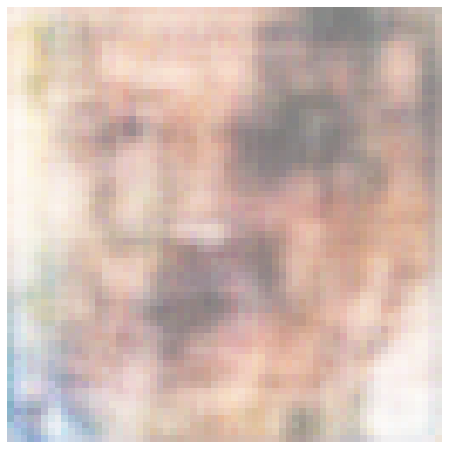

Epoch [5 / 28] G loss: 2.655648708343506 D loss: 0.6735623478889465


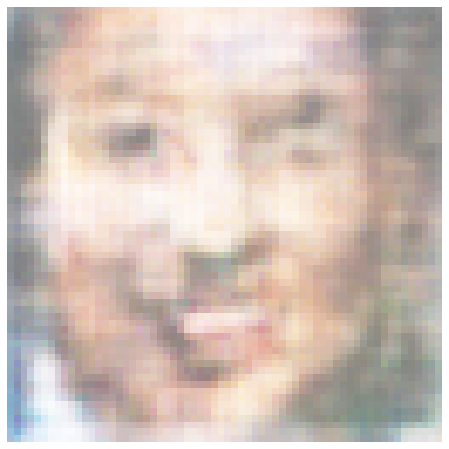

Epoch [6 / 28] G loss: 2.8068926334381104 D loss: 0.4369540810585022


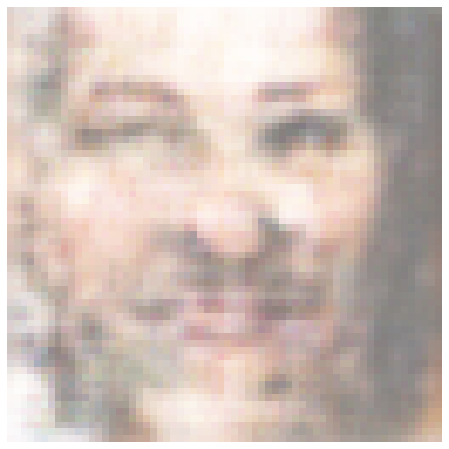

Epoch [7 / 28] G loss: 2.731196641921997 D loss: 1.3183146715164185


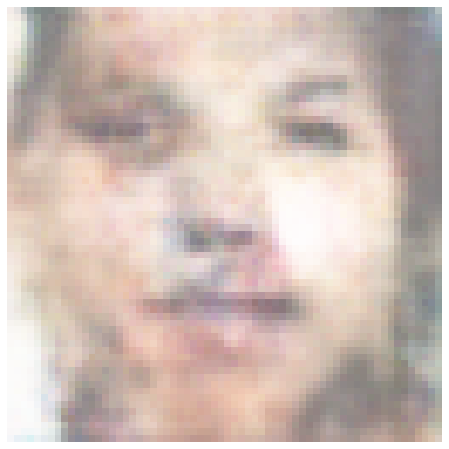

Epoch [8 / 28] G loss: 2.3223254680633545 D loss: 0.5642231702804565


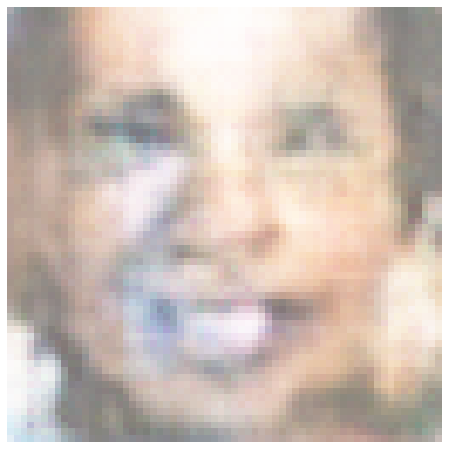

Epoch [9 / 28] G loss: 2.7748520374298096 D loss: 0.436506986618042


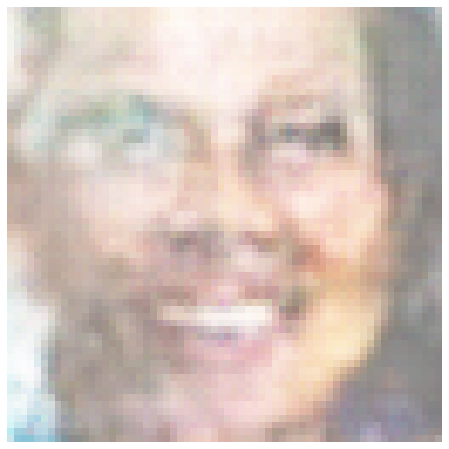

Epoch [10 / 28] G loss: 4.209438323974609 D loss: 0.6241671442985535


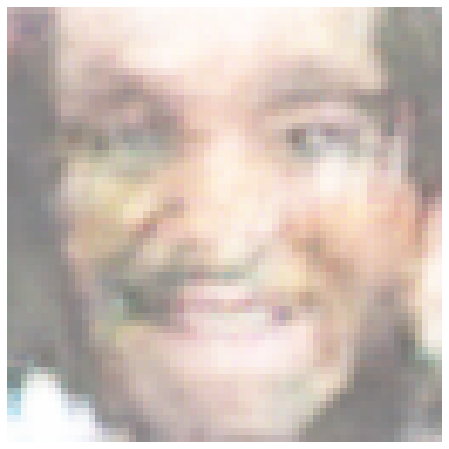

Epoch [11 / 28] G loss: 2.0846266746520996 D loss: 1.065791130065918


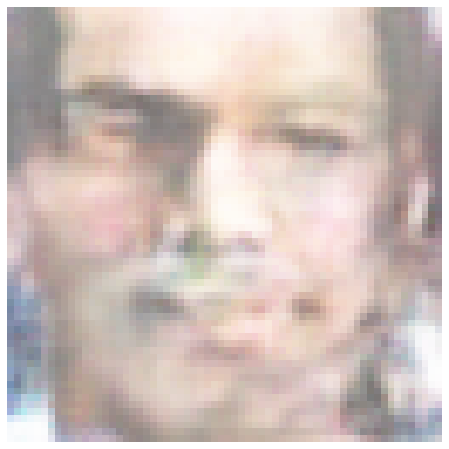

Epoch [12 / 28] G loss: 2.1450188159942627 D loss: 1.3944756984710693


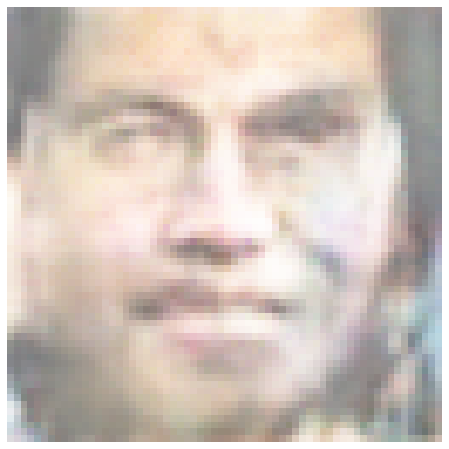

Epoch [13 / 28] G loss: 3.336817979812622 D loss: 0.5261327028274536


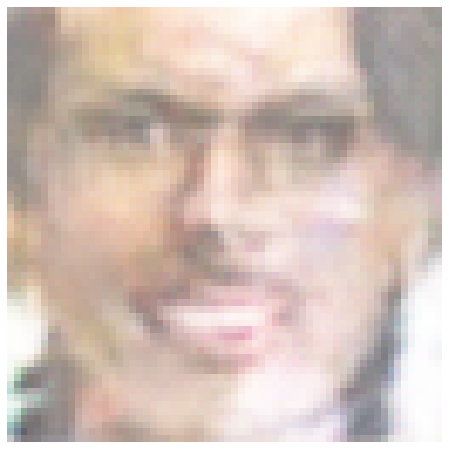

Epoch [14 / 28] G loss: 3.3236985206604004 D loss: 0.49364930391311646


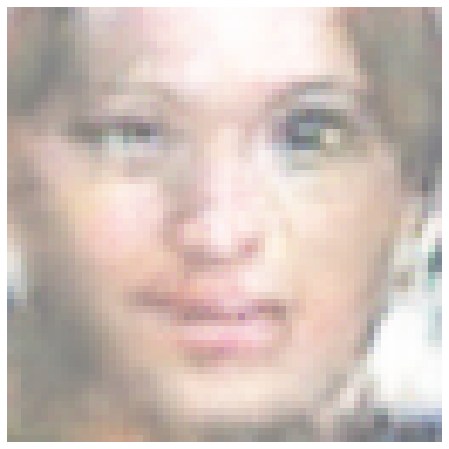

Epoch [15 / 28] G loss: 3.714817523956299 D loss: 0.7755451798439026


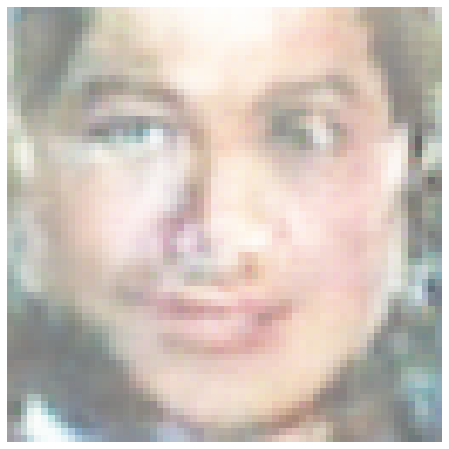

Epoch [16 / 28] G loss: 2.949023962020874 D loss: 0.4628690481185913


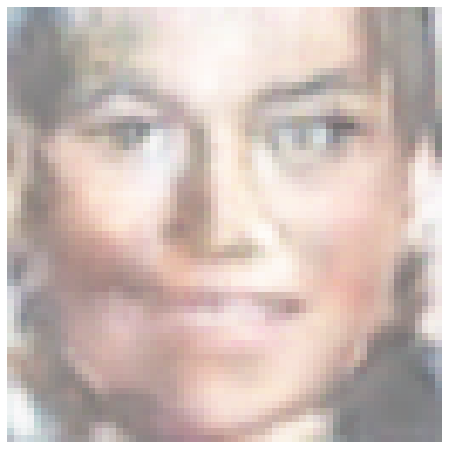

Epoch [17 / 28] G loss: 4.404207229614258 D loss: 0.560149610042572


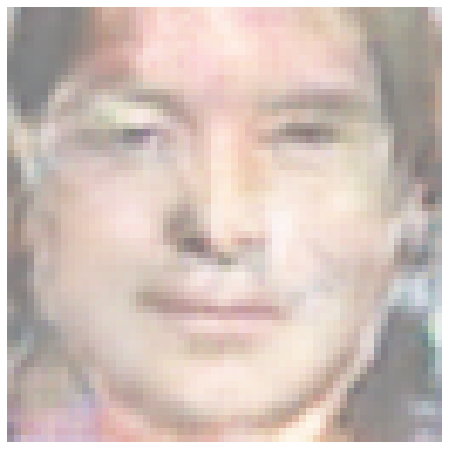

Epoch [18 / 28] G loss: 3.7770354747772217 D loss: 0.4698445796966553


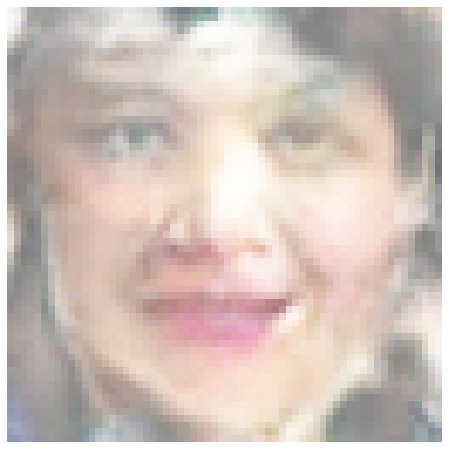

Epoch [19 / 28] G loss: 4.9005327224731445 D loss: 0.7100095748901367


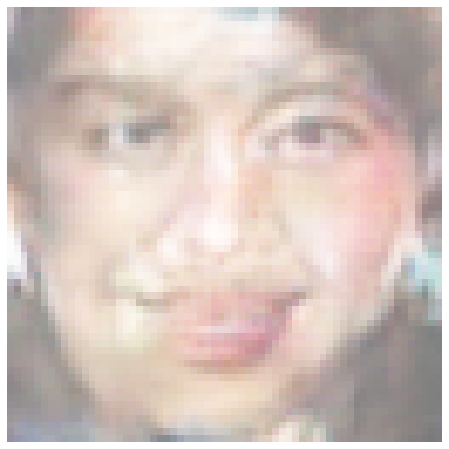

Epoch [20 / 28] G loss: 4.260063648223877 D loss: 0.43339279294013977


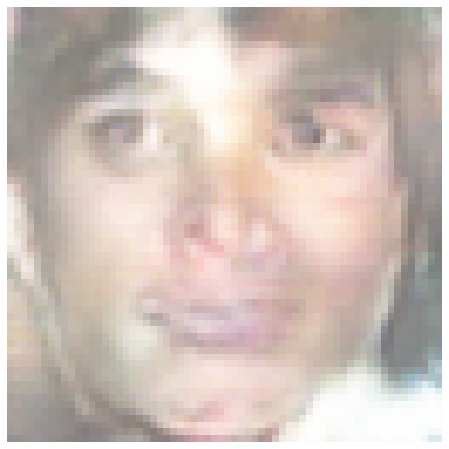

Epoch [21 / 28] G loss: 3.5193979740142822 D loss: 0.3955785632133484


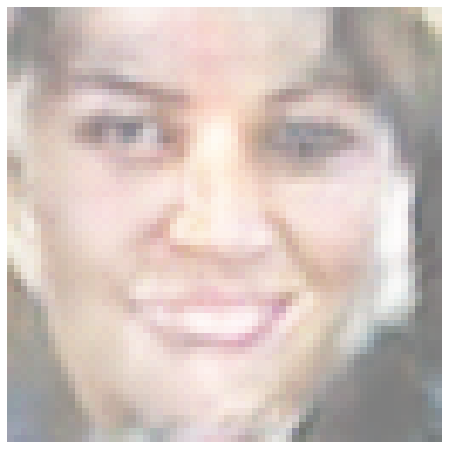

Epoch [22 / 28] G loss: 2.7259254455566406 D loss: 0.6182994246482849


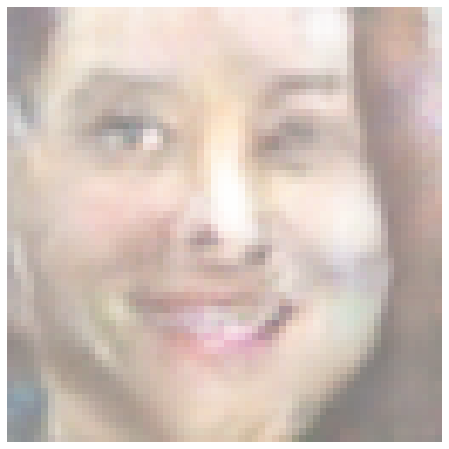

Epoch [23 / 28] G loss: 3.5350918769836426 D loss: 0.3246223032474518


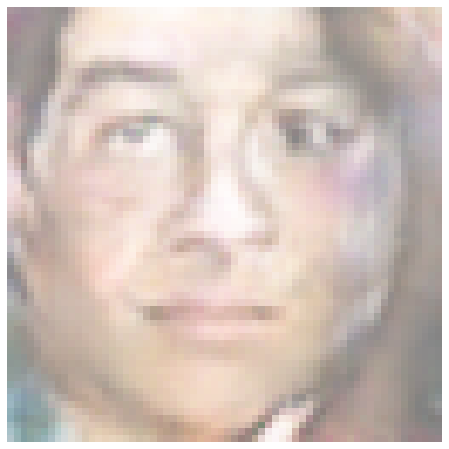

Epoch [24 / 28] G loss: 4.021752834320068 D loss: 0.42553234100341797


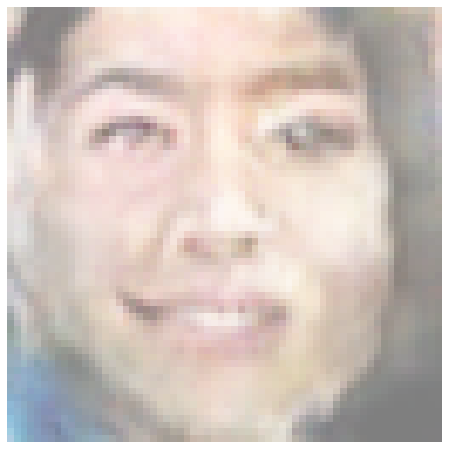

Epoch [25 / 28] G loss: 3.5761489868164062 D loss: 0.38608887791633606


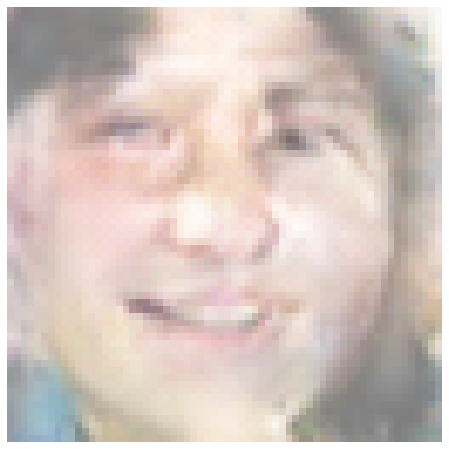

Epoch [26 / 28] G loss: 4.333963871002197 D loss: 0.42143648862838745


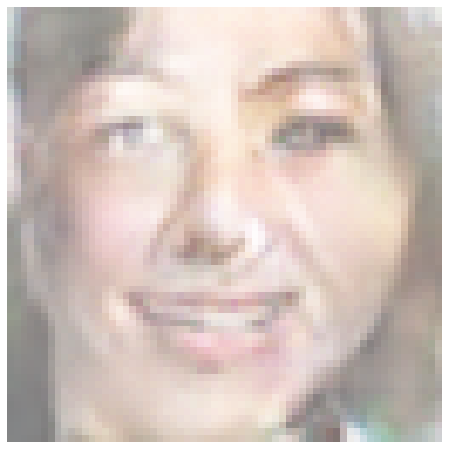

Epoch [27 / 28] G loss: 4.778634548187256 D loss: 0.2847442328929901


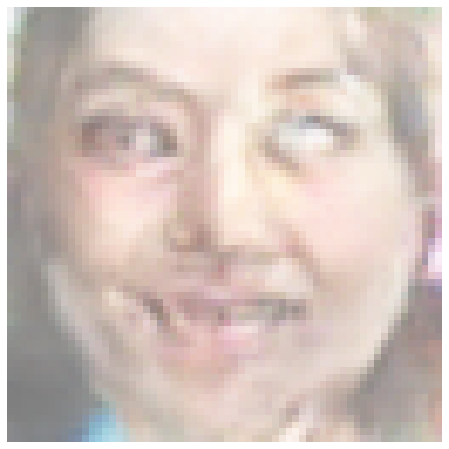

Epoch [28 / 28] G loss: 2.9915127754211426 D loss: 0.3206411600112915


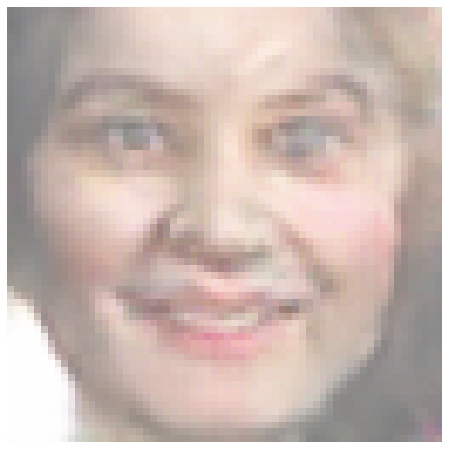

Avg per epoch time: 57.58 sec, total 28 epochs time: 26.93 min
Training finished!
...saving training results


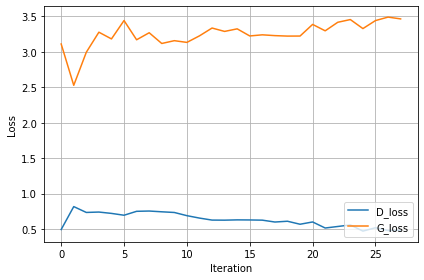

In [81]:
#######################################################################################################
# TODO 7: train a DCGAN on the face images
#######################################################################################################
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dset_name = 'faces' #pick a meaningful name
result_dir = '{}_DCGAN'.format(dset_name)

device = torch.device("cuda:0")

num_epochs=28

#######################################################################################################
# TODO 5a: Fill code for training setup
#######################################################################################################

# define networks
G = Generator_face()
G.weight_init(0, 0.02)
G = G.cuda()
D = Discriminator_face()
D.weight_init(0, 0.02)
D = D.cuda()
# print(G, D)


# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[0.5, 0.999])
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[0.5, 0.999]) 
loss_function = nn.BCELoss()

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(result_dir+'/Random'):
    os.mkdir(result_dir+'/Random')
if not os.path.isdir(result_dir+'/Fixed'):
    os.mkdir(result_dir+'/Fixed')

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    for real, _ in data_loader:
        real = real.to(device)
        batch_size = real.size(0)

        # generate random latent vector z and real and fake labels 
    
        z = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 100))).float().cuda()
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()
        
        # generate fakes    

        fake_images = G(z)
        
        # evaluate fakes
        
        fake_evals = D(fake_images)

        # evaluate real minibatch
         
        real_evals = D(real)
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = loss_function(fake_evals, fake_labels) + loss_function(real_evals, real_labels)

        # train discriminator D step
        D.zero_grad()
        G.zero_grad()
        D_train_loss.backward(retain_graph=True)
        D_optimizer.step()    
        
        # train generator to output an image that is classified as real
        
        z = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 100))).float().cuda()
        fake_images = G(z)
        fake_evals = D(fake_images)        
        G_train_loss = loss_function(fake_evals, real_labels)
        
        # train generator G step
        D.zero_grad()
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_result( epoch, save=True, path=result_dir + '/Random/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=False, inverted=False)
    show_result( epoch, save=True, show=True, path=result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True, inverted=False)
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)

end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot the loss curves    
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# Visualize the training progress as an animated GIF
images = []
for e in range(num_epochs):
    img_name = result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/DCGAN_generation_animation.gif', images, fps=5)

### 8) Create a latent space walk of the Face Generator you trained (5 points)
To that end, generate as many random latents as your animation has number of frames. Then, use a gaussian filter on those latents in order to create a smooth blending between adjacent frames in the animation. Have a look at `scipy.ndimage.gaussian_filter` for that purpose. Make sure that your animation can loop endlessly, i.e. the last frames and the first frames of the animation also blend. The $\sigma$ value of the gaussian filter defines how many frames are blended; use the given parameter values of the function to control this value.<br>
Your output should look like this (or better):

<img src='img/Faces_DCGAN_latent_walk_1.gif' style='margin: 0px 10px' align='left' width="128">

<img src='img/Faces_DCGAN_latent_walk_2.gif' style='margin: 0px 10px' align='left' width="128">

<img src='img/Faces_DCGAN_latent_walk_3.gif' style='margin: 0px 10px' align='left' width="128">

In [104]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [116]:
def generate_latent_walk(duration_sec=20.0, smoothing_sec=1.0, fps=30):
    #######################################################################################################
    # TODO 8: create a smoothly interpolated loop through random latent space values
    #######################################################################################################
    
    num_frames = 4
    
    images = []
    z_1 = torch.from_numpy(np.random.uniform(-1, 1, size=(num_frames, 100))).float().cuda()
    z_2 = torch.from_numpy(np.random.uniform(-1, 1, size=(num_frames, 100))).float().cuda()
    z_3 = torch.from_numpy(np.random.uniform(-1, 1, size=(num_frames, 100))).float().cuda()
    count=0
    interp = 100
    for i in range(interp):
        count += 1
        z = (interp - i) /interp * z_1 + i / interp * z_2
        tmp_images = G(z).detach().cpu()
        tmp_images = torch.where(tmp_images < 0, torch.zeros(num_frames, 3, 64, 64), tmp_images)
        grid = utils.make_grid(tmp_images, nrow=num_frames)
        images.append(np.transpose(grid, (1, 2, 0)))
    
    for i in range(interp):      
        count += 1
        z = (interp - i) /interp * z_2 + i / interp * z_3
        tmp_images = G(z).detach().cpu()
        tmp_images = torch.where(tmp_images < 0, torch.zeros(num_frames, 3, 64, 64), tmp_images)
        grid = utils.make_grid(tmp_images, nrow=num_frames)
        images.append(np.transpose(grid, (1, 2, 0)))
    
    for i in range(interp):
        count += 1
        z = (interp - i) /interp * z_3 + i / interp * z_1
        tmp_images = G(z).detach().cpu()
        tmp_images = torch.where(tmp_images < 0, torch.zeros(num_frames, 3, 64, 64), tmp_images)
        grid = utils.make_grid(tmp_images, nrow=num_frames)
        images.append(np.transpose(grid, (1, 2, 0)))
        
    imageio.mimsave(result_dir + '/latent_space_walk.gif', images, fps=fps)
    print(count)
    print(len(images))

generate_latent_walk()       

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

300
300


<img src='faces_DCGAN/latent_space_walk.gif' style='margin: 0px 10px' align='left' width="1024">

## Assignment 4B: Conditional DCGAN

Our previous Generator network was generating random outputs for each input latent vector without any measure of control over the output. 
Now, we would like to add some control mechanism such that we can determine the class for a generated image, e.g. generate only the number $5$ or images from the category $Shirt$.

The expected output of this GAN should look like this (or better):

<img src="img/cond_DCGAN_MNIST.png" align='left' width="550">
<img src="img/cond_DCGAN_fashionMNIST.png" align='left' width="550">

For simplicity, we will use either _MNIST_ or _FashionMNIST_ at $32\times32$ grayscale for this exercise again.

For a class-conditioned output, we need to modify both the generator as well as the discriminator network to accept a class label as part of the input. These labels need to be transformed from a "categorical" input to a numerical vector. Use `torch.nn.Embedding` to transform the label to such an embedding space.

### 8) Modify Networks for conditional GANs (4 points)

Select appropriate training hyperparameters.

In [117]:
# TODO: choose reasonable values
batch_size = 64
num_epochs = 32
learning_rate = 0.0002

### 9) Design a conditional discriminator network (8 points)

Below diagrams shows the architecture that you're expected to implement

<img src="img/DCGAN_Discriminator_conditional.png" align='left' width="900">

In [141]:
#######################################################################################################
#TODO 9: update the discriminator network to incorporate the label input
#######################################################################################################
class Discriminator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = conv(1, 128, 4, batch_norm=False)
        self.conv2 = conv(128, 256, 4)
        self.conv3 = conv(257, 512, 4)
        self.conv4 = conv(512, 512, 4, stride=1, padding=0)
        self.fc = nn.Linear(512, 1)
        self.emb = nn.Embedding(n_classes, 50)
        self.fc1 = nn.Linear(50, 64)
        self.LRelu = nn.LeakyReLU(0.2)        

    # forward method
    def forward(self, input, labels):
        batch_size = input.size()[0]
        x = self.LRelu(self.conv1(input))
        x = self.LRelu(self.conv2(x))
        y = self.emb(labels)
        y = self.fc1(y)
        y = y.view(-1, 1, 8, 8)
        x = self.LRelu(self.conv3(torch.cat((x, y), 1)))
        x = torch.sigmoid(self.conv4(x))
        x = x.view(batch_size, -1)
        x = torch.sigmoid(self.fc(x))
        return x

### 8) Design a conditional generator network (8 points)

<img src="img/DCGAN_Generator_conditional.png" align='left' width="900">

In [142]:
#######################################################################################################
#TODO 10: update the generator network to incorporate the label input
#######################################################################################################
class Generator(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.fc = nn.Linear(100, 512)
        self.tr_conv1 = deconv(512, 512, 4, stride=1, padding=0)
        self.tr_conv2 = deconv(512, 256, 4)
        self.tr_conv3 = deconv(257, 128, 4)
        self.tr_conv4 = deconv(128, 1, 4, batch_norm=False)
        self.emb = nn.Embedding(n_classes, 50)
        self.fc1 = nn.Linear(50, 64)
        

    # forward method
    def forward(self, inp, labels):
        batch_size = inp.size()[0]
        x = self.fc(inp)
        x = x.view(batch_size, 512, 1, 1)
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        y = self.emb(labels)
        y = self.fc1(y)
        y = y.view(-1, 1, 8, 8)
        x = torch.cat((x, y), 1)
        x = F.relu(self.tr_conv3(x))
        x = torch.tanh(self.tr_conv4(x))
        return x


#### Complete the output function (5 points)

In [153]:
# output generated samples from the current state of the generator network
n_samples = 5

#######################################################################################################
# TODO 11: generate a fixed noise vector and a fixed set of labels to evaluate the output of the generator
# with the same noise parameters as training progresses.
# Arrange the labels into a grid to show same label outputs in the same column (see example results above) 
#######################################################################################################
fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(n_samples, 100))).repeat(10, 1).float().cuda()
fixed_labels = torch.from_numpy(np.arange(10).repeat(n_samples)).cuda()

def show_conditional_result(num_epoch, show=False, save=False, n_classes=10, n_samples=5, path='result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z, fixed_labels).cpu()
            fake = convertColors(fake)
        else:
            # TODO generate a new random noise vector and a grid of labels
            z = torch.from_numpy(np.random.uniform(-1, 1, size=(n_samples, 100))).repeat(10, 1).float().cuda()
            labels = torch.from_numpy(np.arange(10).repeat(n_samples)).cuda()

            fake = G(z, labels).cpu()
            fake = convertColors(fake)

        fig, ax = plt.subplots(figsize=(20, 10))
        image = utils.make_grid(fake.data, n_classes, 1)

        plt.imshow(np.transpose(image, (1, 2, 0)))

        ax.axis('off')

        plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()   

#### Complete the training setup (5 points) and training loop (10 points)

In [154]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5],
                        [0.5])
    ])
train_dataset = datasets.FashionMNIST(root="data/", transform=transform, download=True)

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  60000
Image size: torch.Size([1, 32, 32])
value range: [ -1.0 - 0.9058823585510254 ]


Training ...
Epoch [1 / 32] G loss: 1.8412145376205444 D loss: 0.7100285887718201


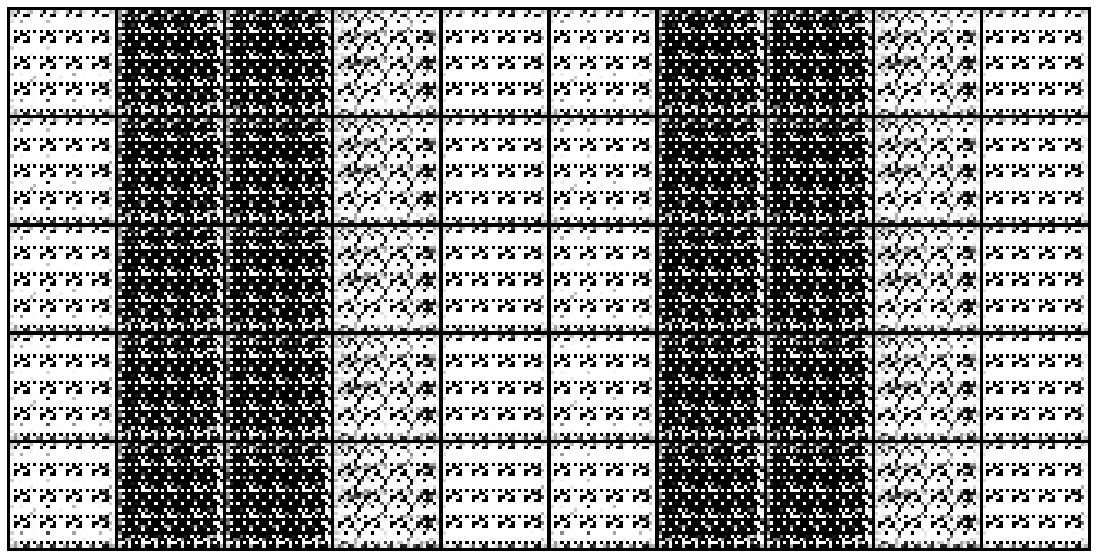

Epoch [2 / 32] G loss: 1.7661728858947754 D loss: 0.5201076865196228


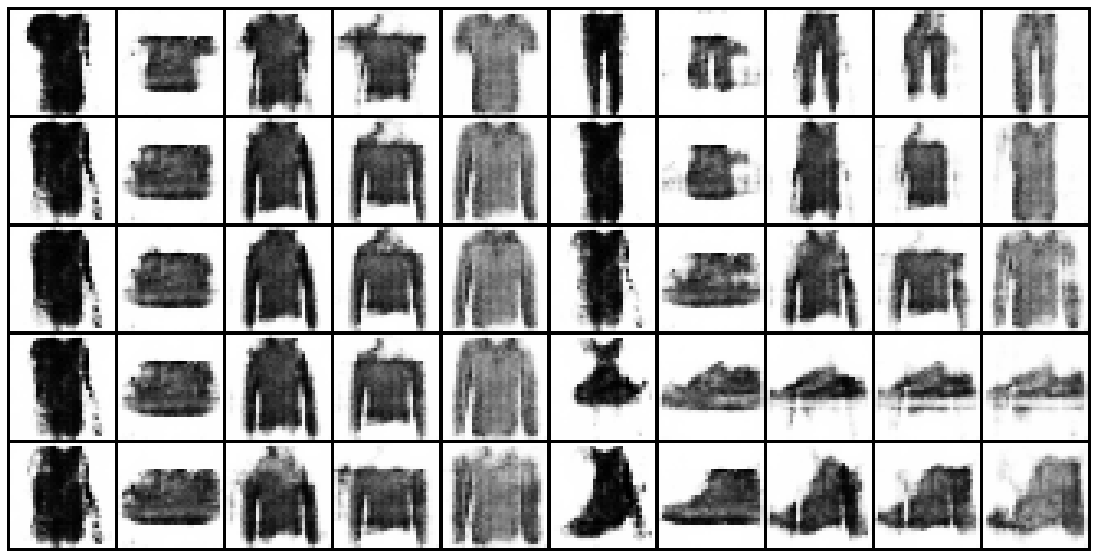

Epoch [3 / 32] G loss: 2.9068922996520996 D loss: 0.23000876605510712


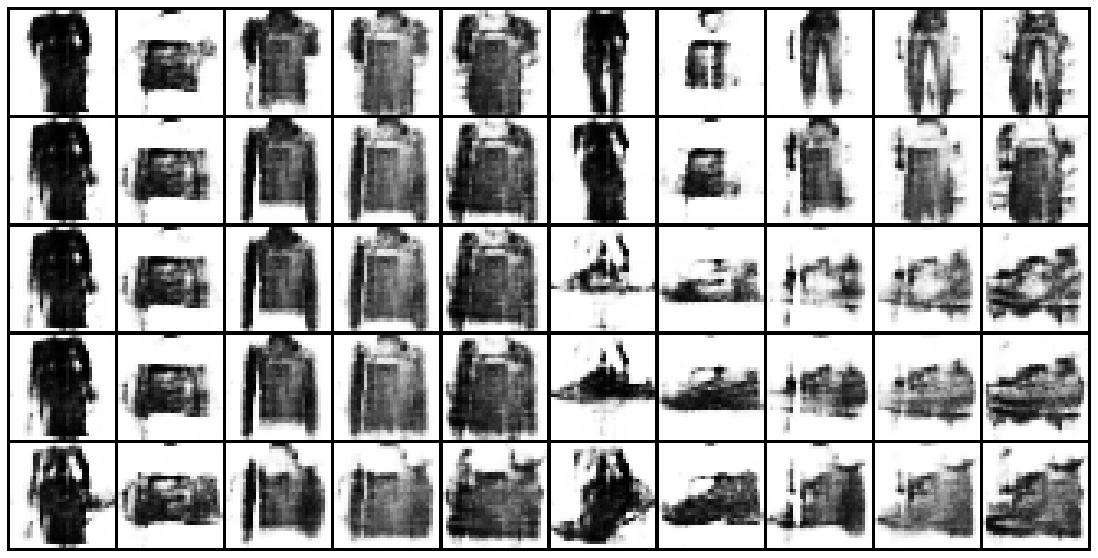

Epoch [4 / 32] G loss: 4.330678462982178 D loss: 0.036731697618961334


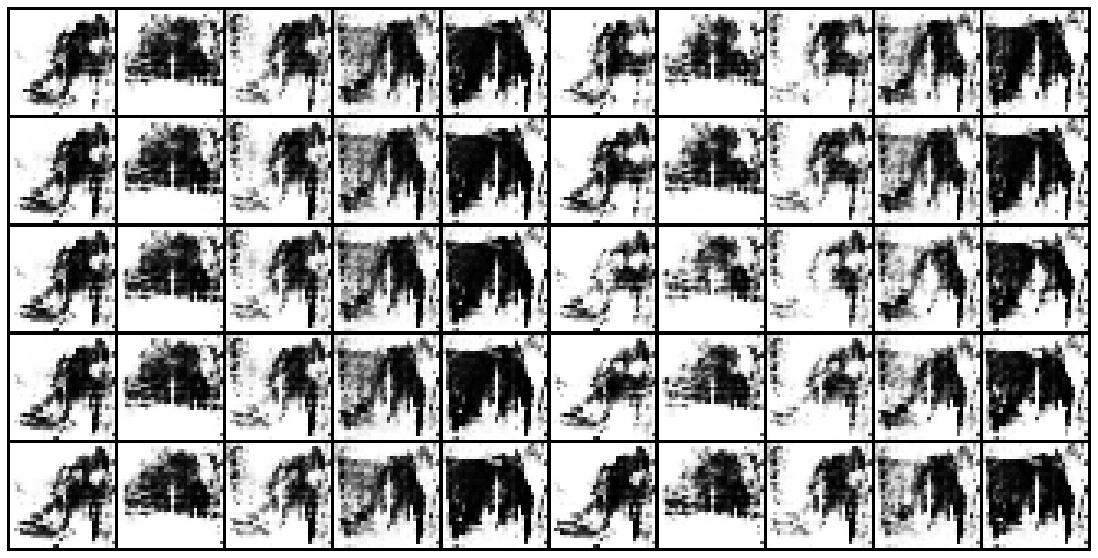

Epoch [5 / 32] G loss: 4.084911346435547 D loss: 0.03220421075820923


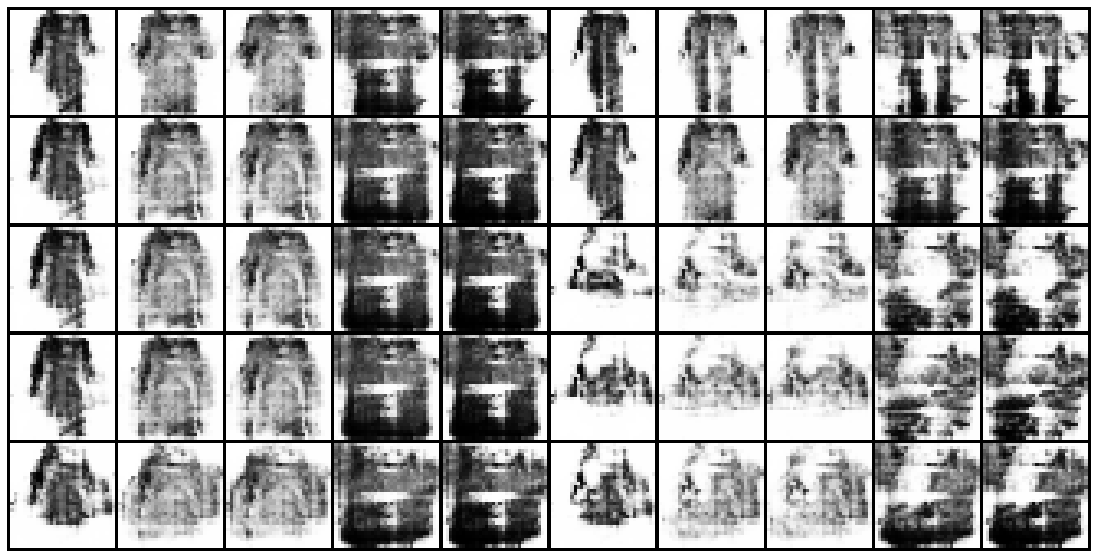

Epoch [6 / 32] G loss: 5.373239517211914 D loss: 0.047350719571113586


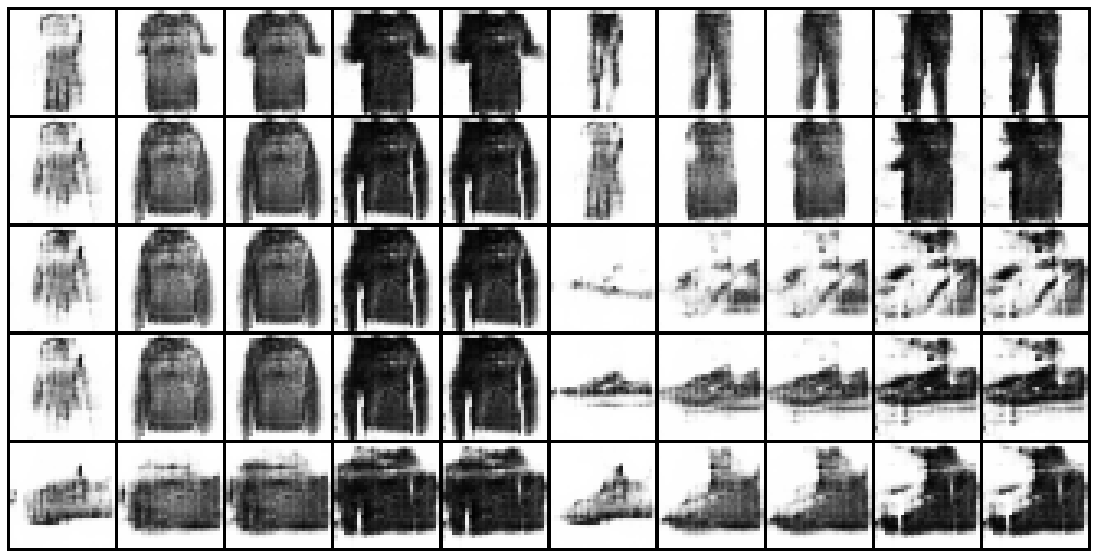

Epoch [7 / 32] G loss: 4.708740711212158 D loss: 0.06298960000276566


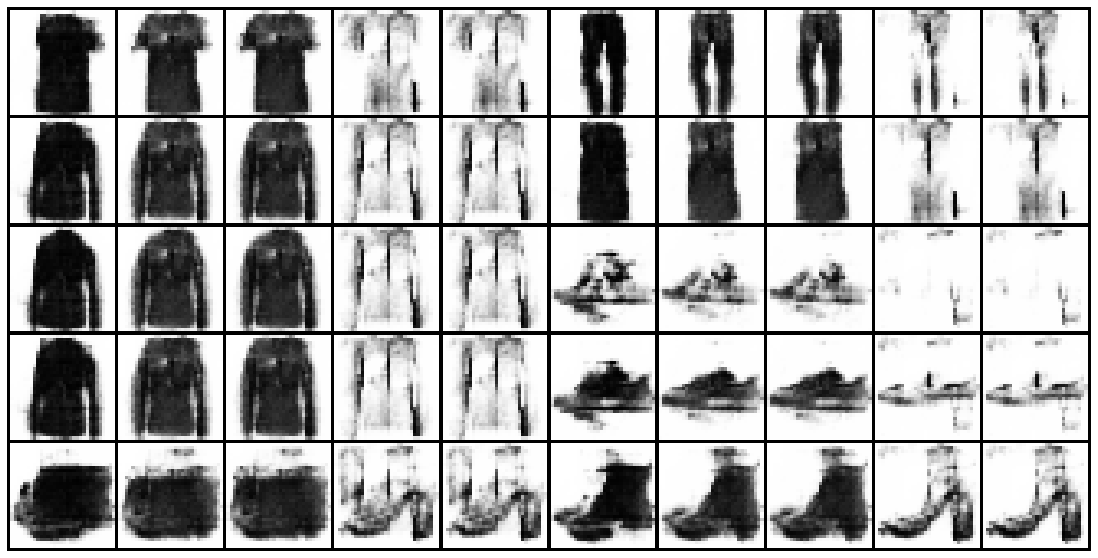

Epoch [8 / 32] G loss: 5.2980756759643555 D loss: 0.011210359632968903


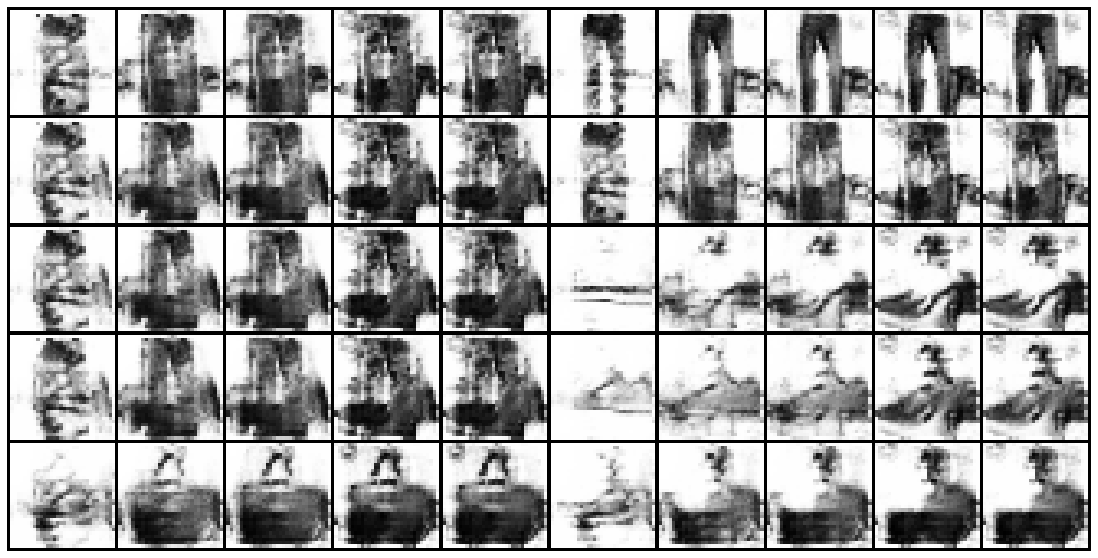

Epoch [9 / 32] G loss: 6.756958484649658 D loss: 0.0055573610588908195


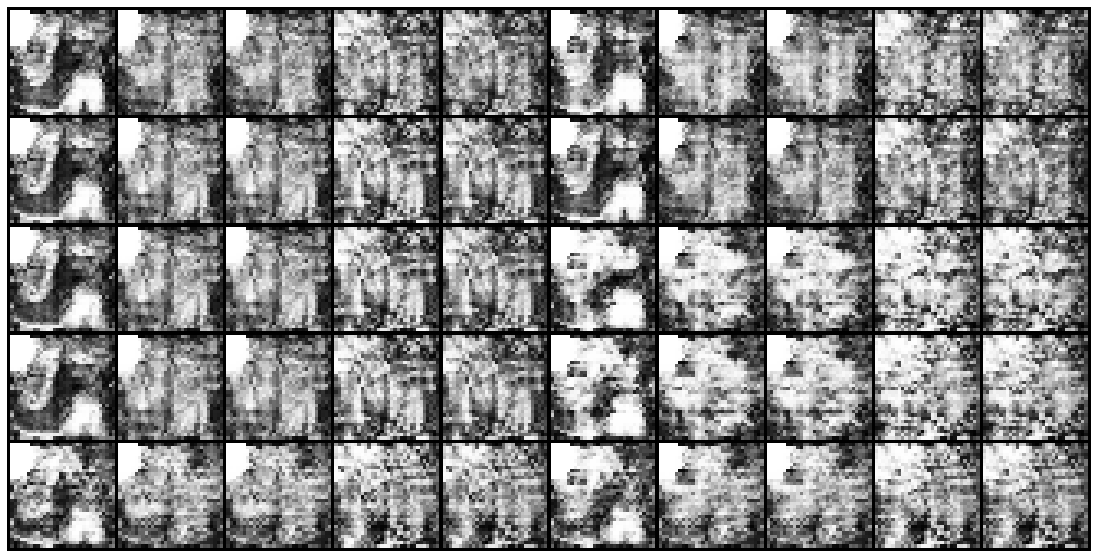

Epoch [10 / 32] G loss: 3.0086045265197754 D loss: 0.2884807586669922


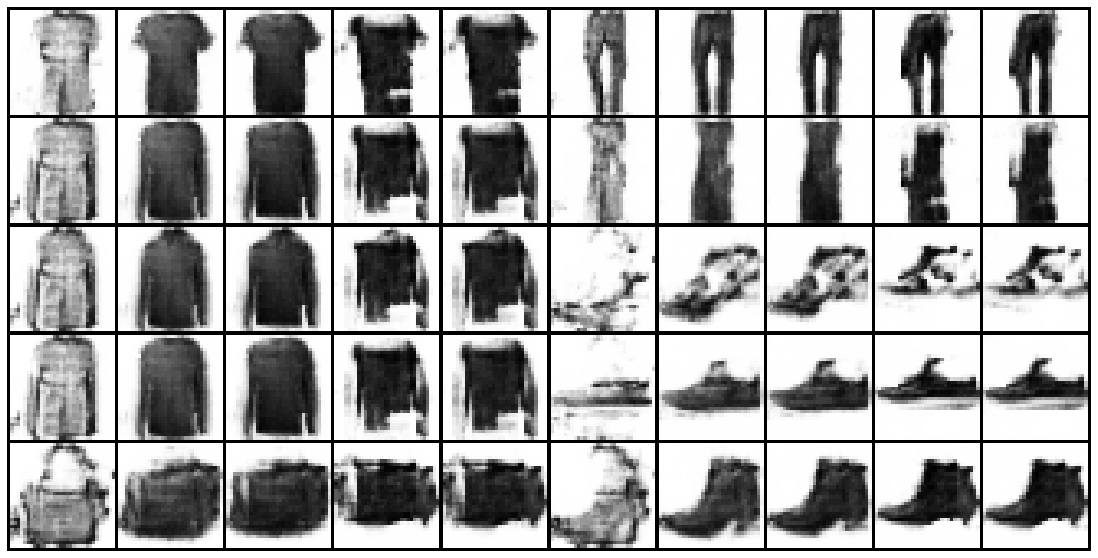

Epoch [11 / 32] G loss: 5.619009971618652 D loss: 0.03131945803761482


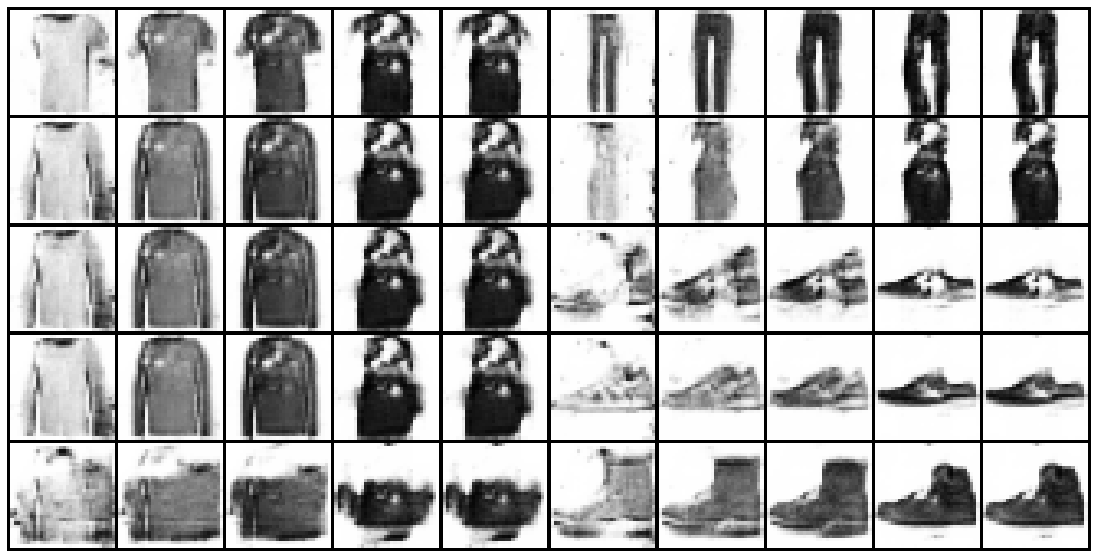

Epoch [12 / 32] G loss: 4.6940016746521 D loss: 0.022867875173687935


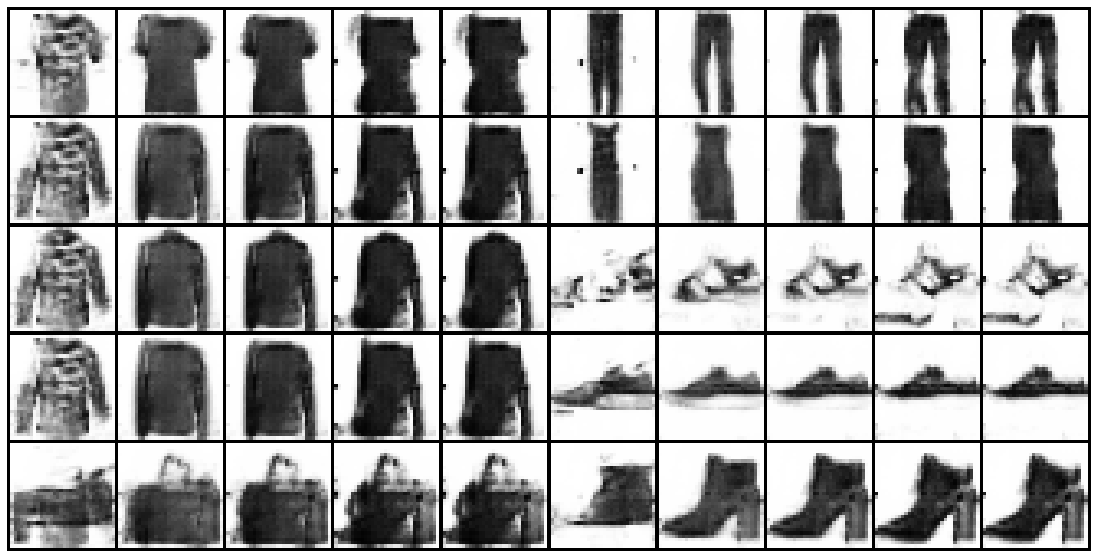

Epoch [13 / 32] G loss: 7.134244918823242 D loss: 0.021204262971878052


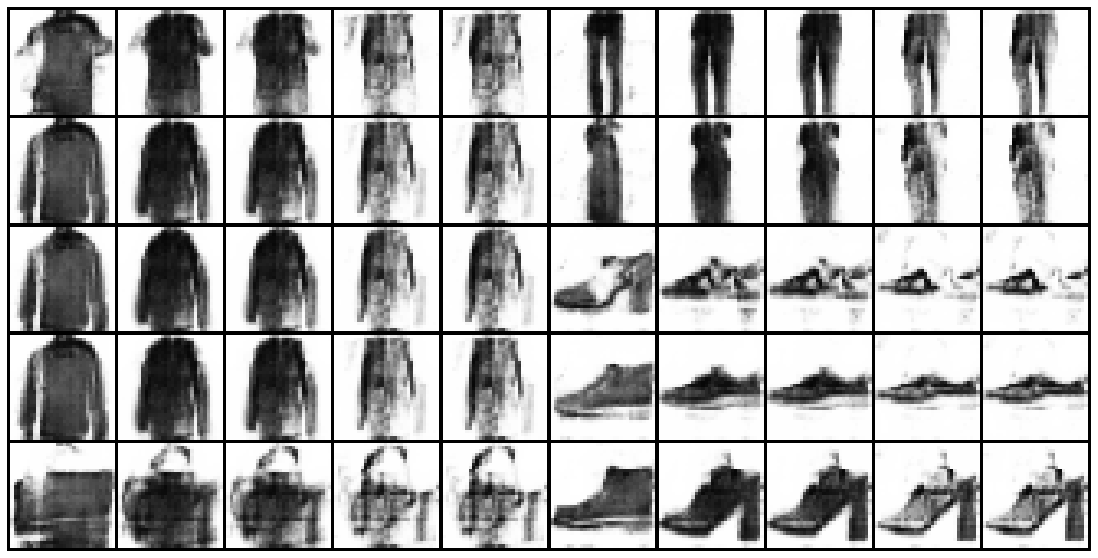

Epoch [14 / 32] G loss: 5.862973213195801 D loss: 0.00853847898542881


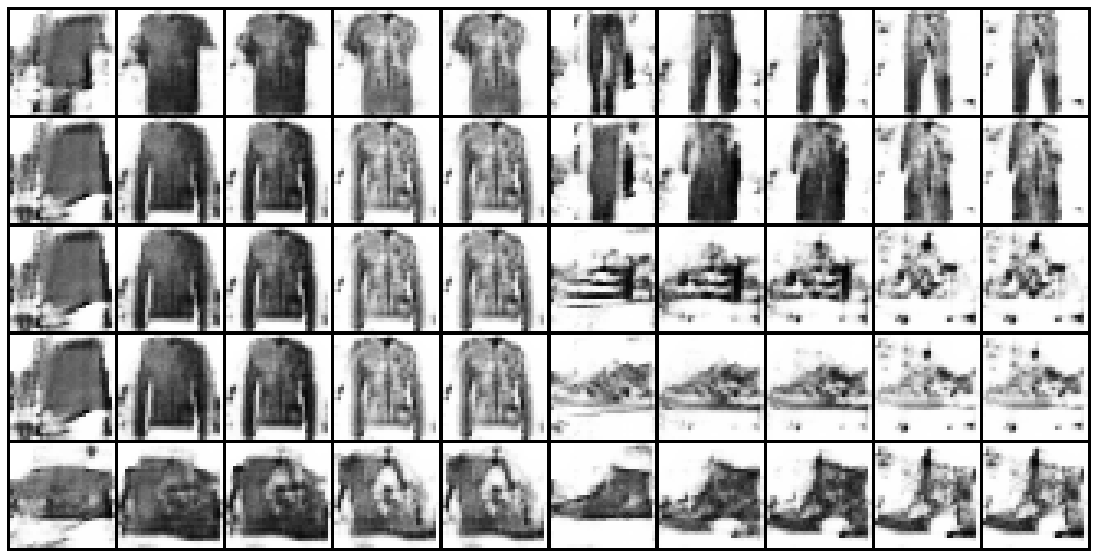

Epoch [15 / 32] G loss: 7.032665729522705 D loss: 0.004160394426435232


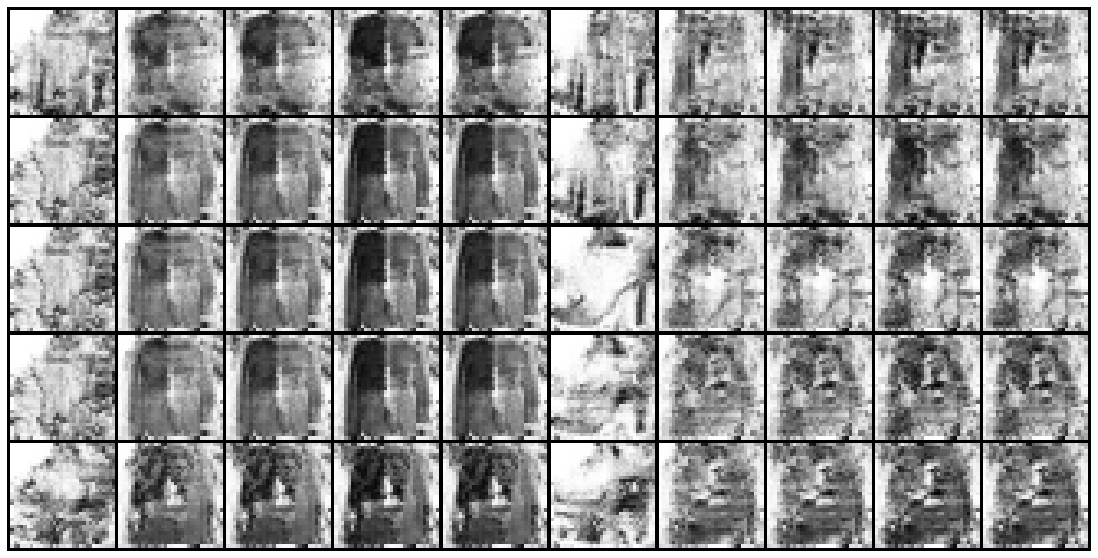

Epoch [16 / 32] G loss: 8.675750732421875 D loss: 0.0008814021130092442


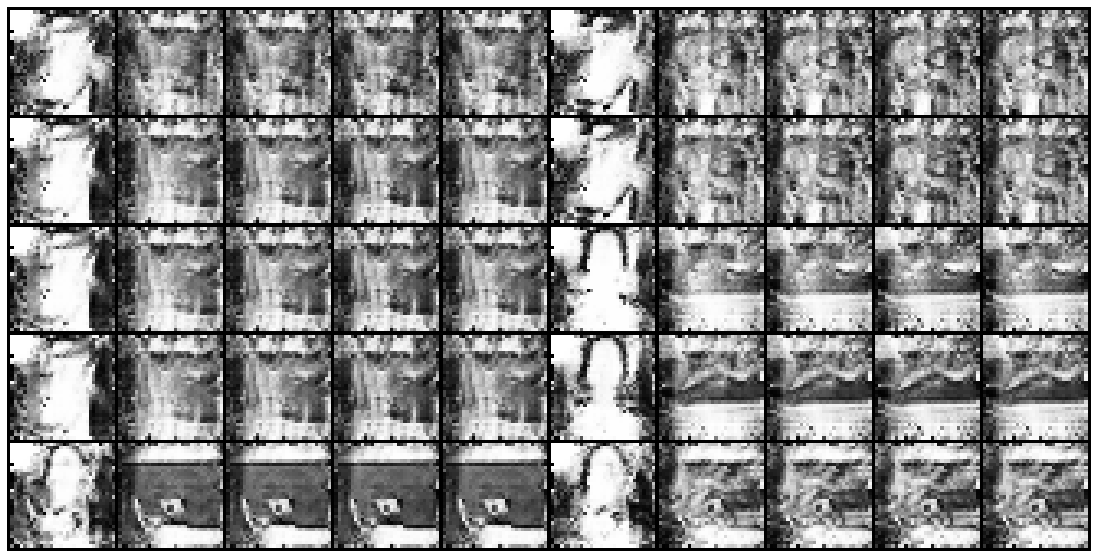

Epoch [17 / 32] G loss: 4.428980827331543 D loss: 0.23131465911865234


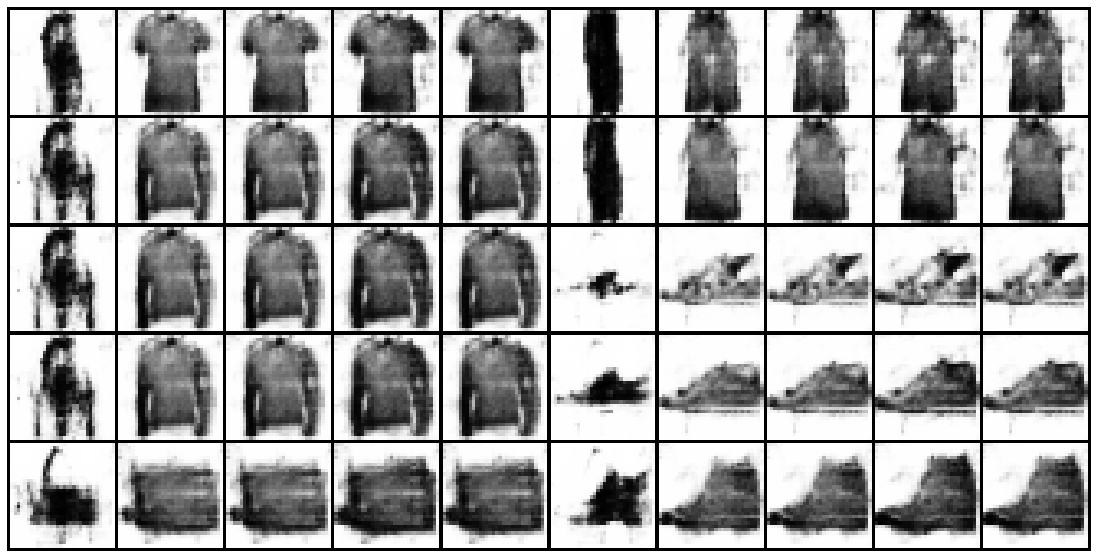

Epoch [18 / 32] G loss: 5.6631598472595215 D loss: 0.12446223199367523


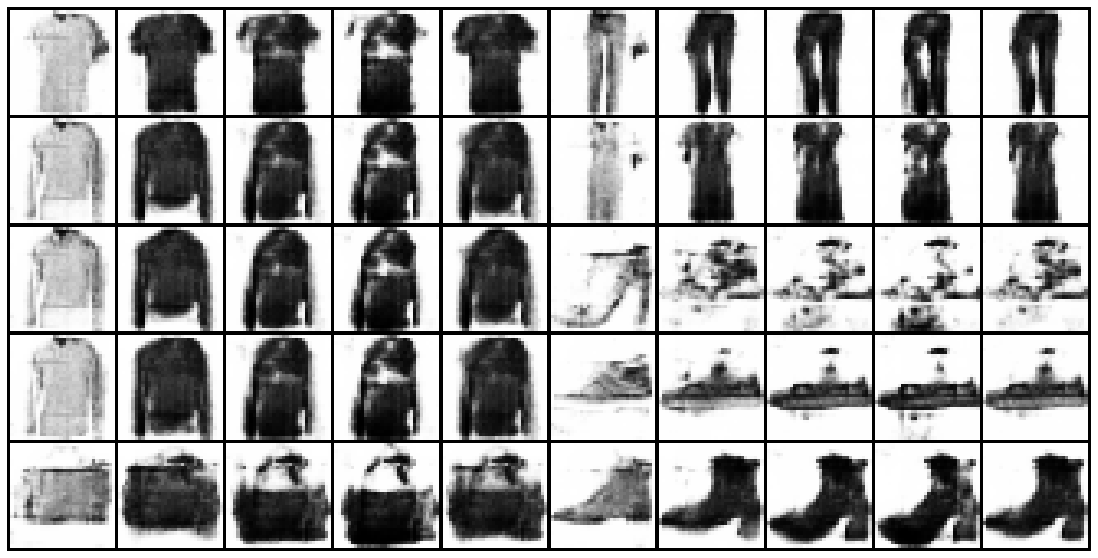

Epoch [19 / 32] G loss: 5.35293436050415 D loss: 0.12419450283050537


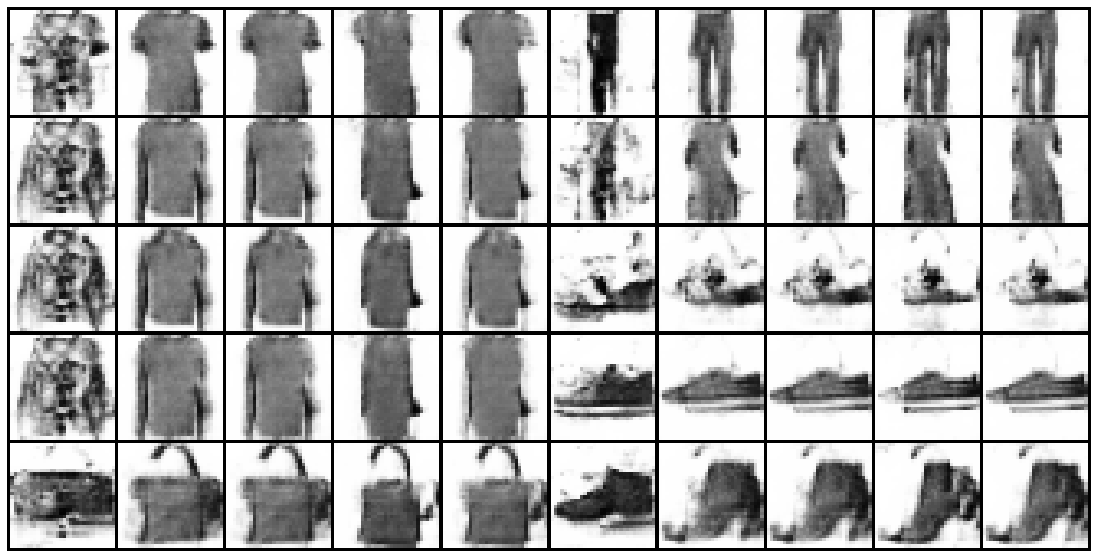

Epoch [20 / 32] G loss: 5.113829612731934 D loss: 0.09784414619207382


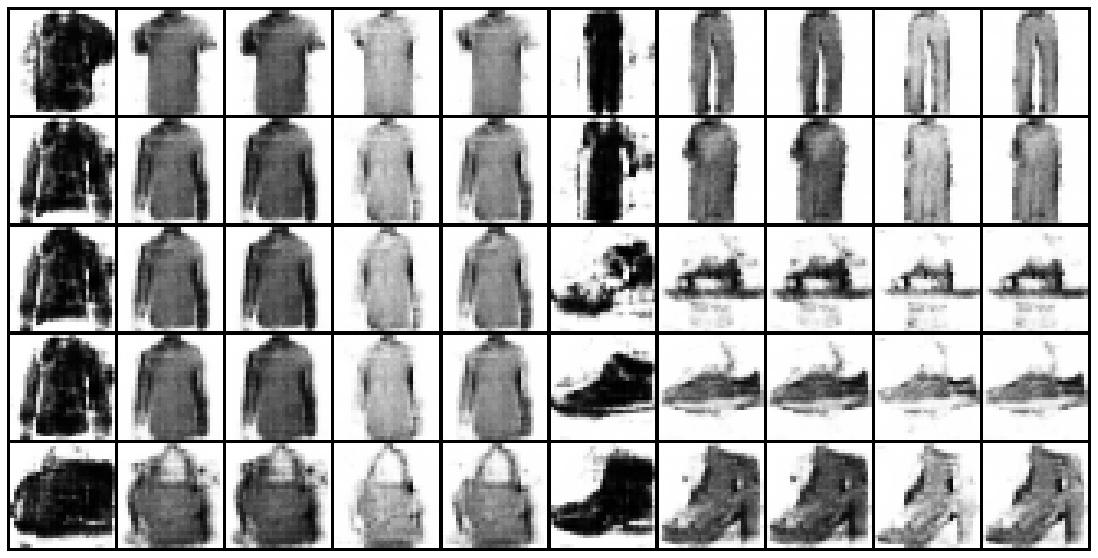

Epoch [21 / 32] G loss: 7.416617393493652 D loss: 0.003279184689745307


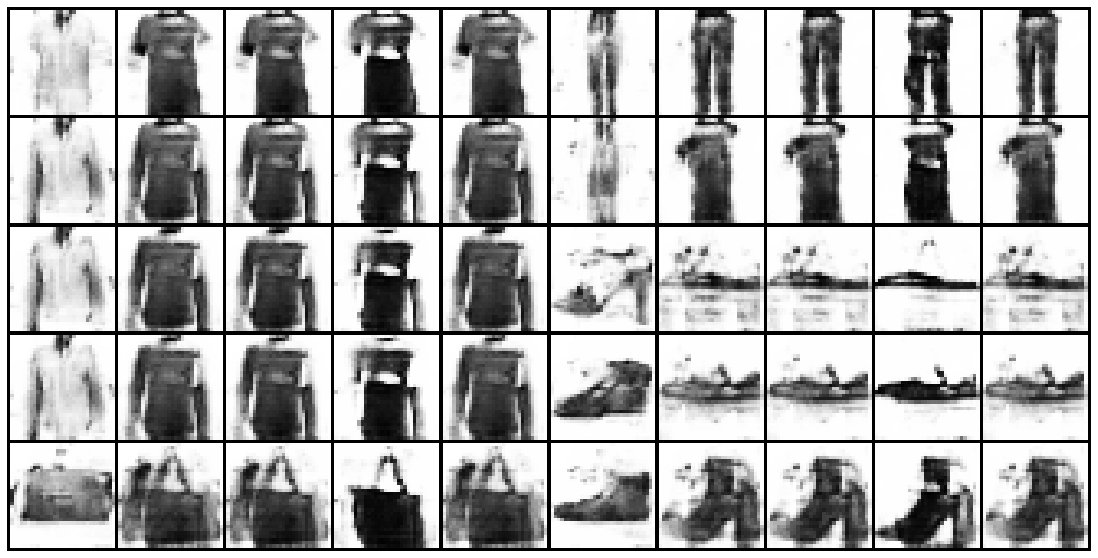

Epoch [22 / 32] G loss: 4.604329586029053 D loss: 0.03652220219373703


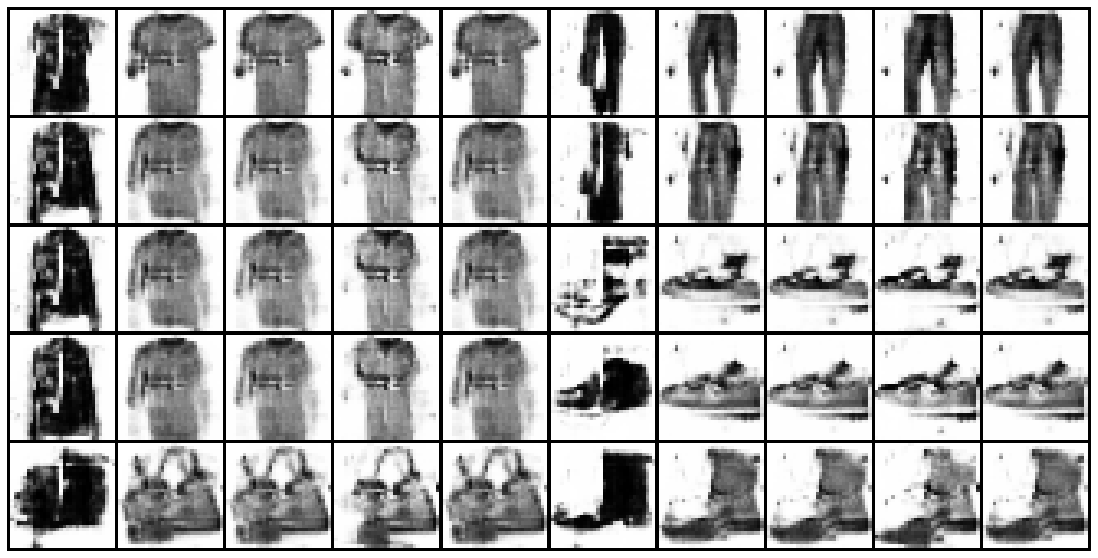

Epoch [23 / 32] G loss: 8.668354034423828 D loss: 0.4077902138233185


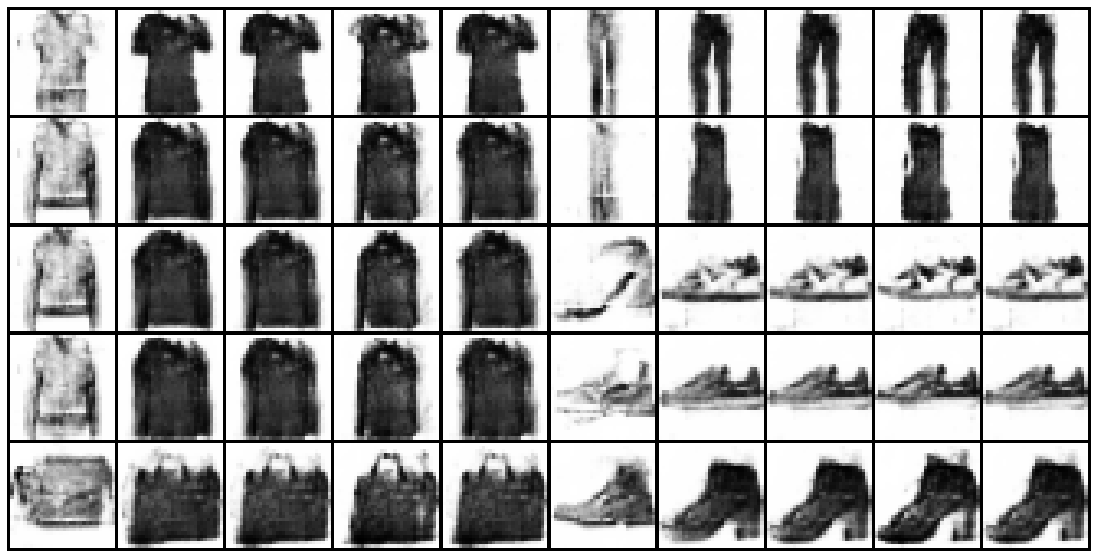

Epoch [24 / 32] G loss: 6.506960868835449 D loss: 0.01836041361093521


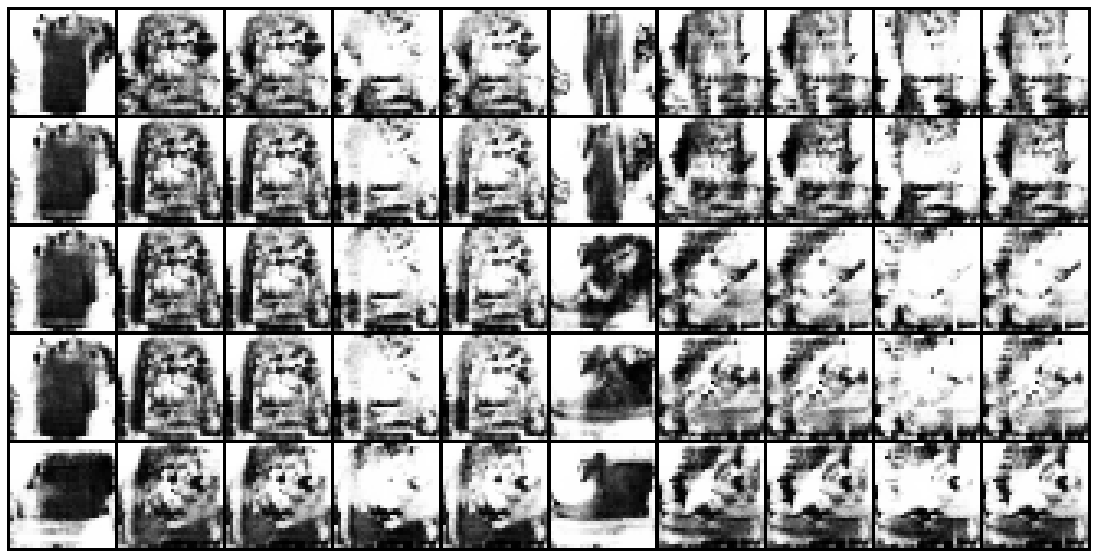

Epoch [25 / 32] G loss: 5.222850799560547 D loss: 0.11561986804008484


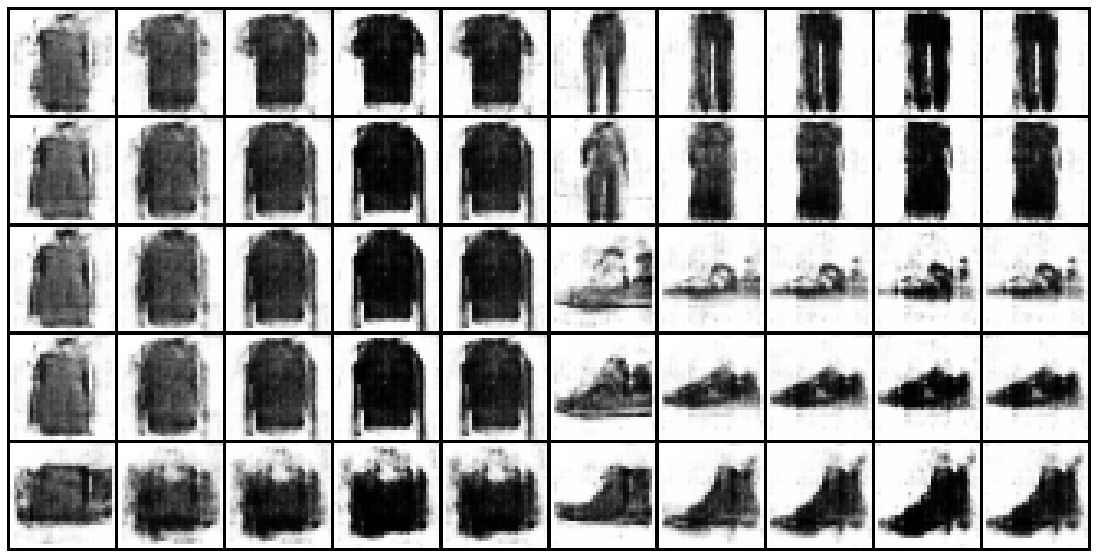

Epoch [26 / 32] G loss: 7.389423370361328 D loss: 0.1425473839044571


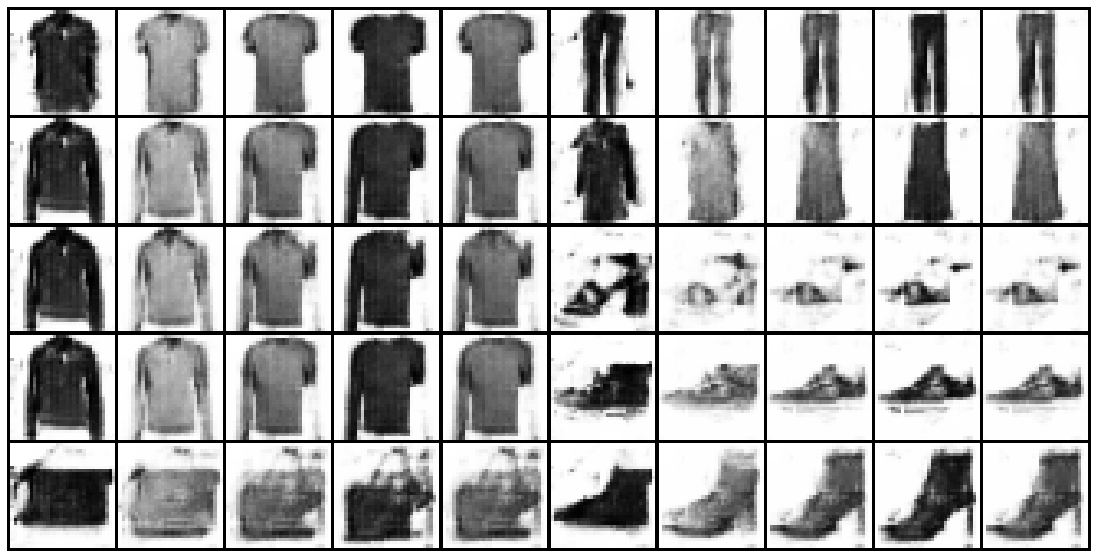

Epoch [27 / 32] G loss: 5.132074356079102 D loss: 0.017832105979323387


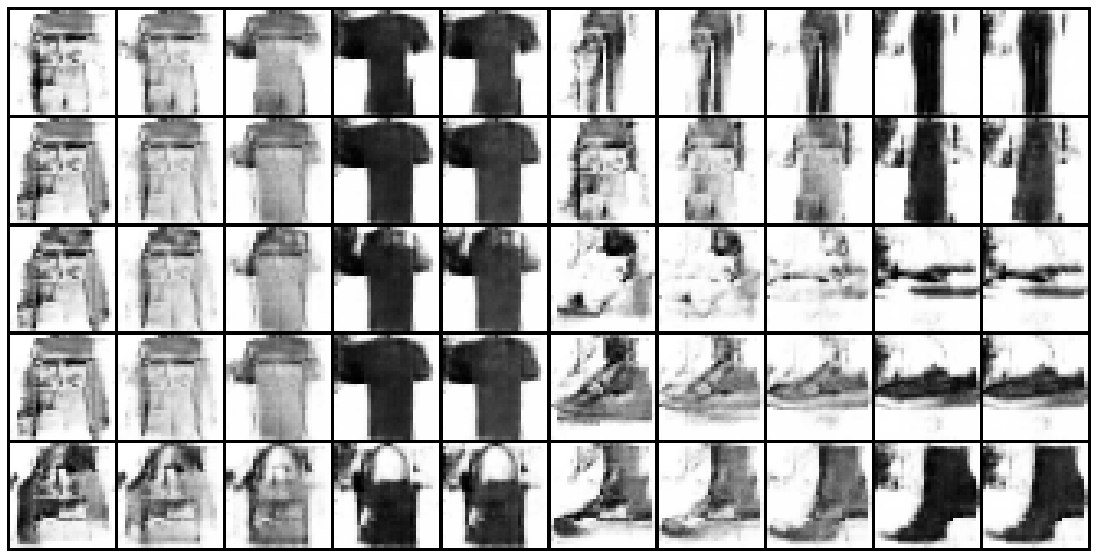

Epoch [28 / 32] G loss: 6.56691312789917 D loss: 0.0028766568284481764


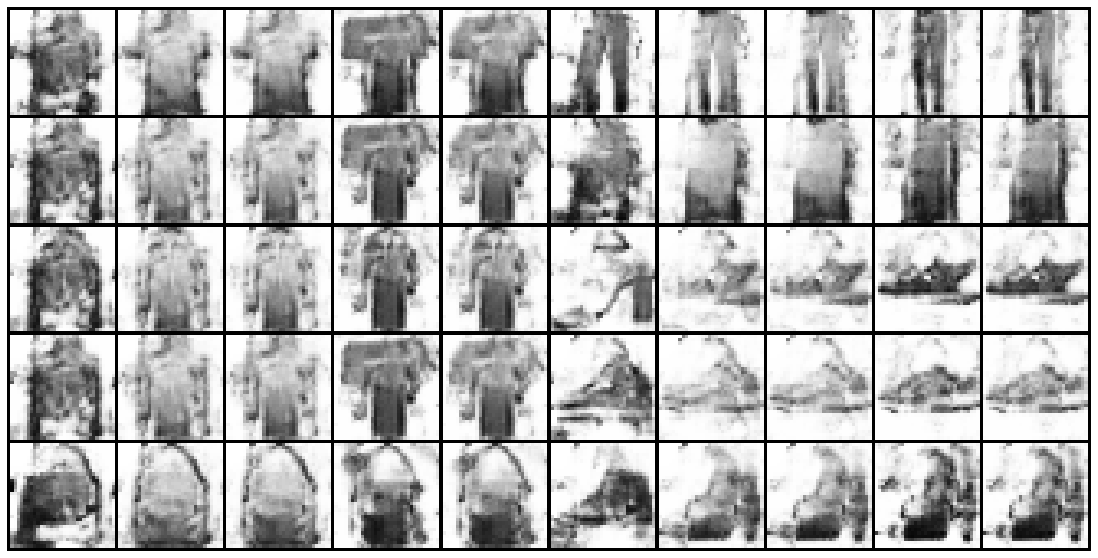

Epoch [29 / 32] G loss: 7.660683631896973 D loss: 0.0015861419960856438


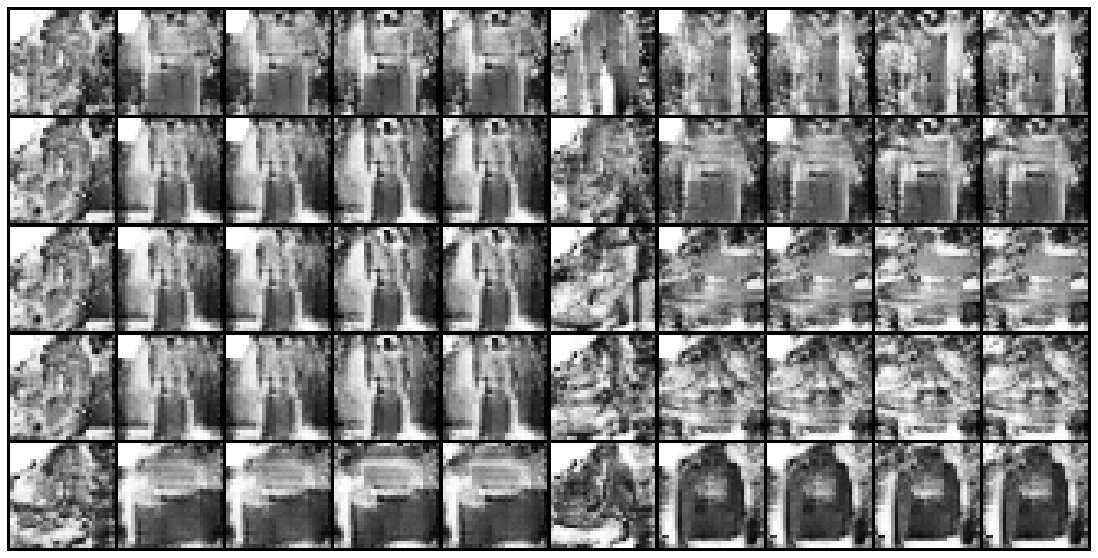

Epoch [30 / 32] G loss: 10.307328224182129 D loss: 0.00038754905108362436


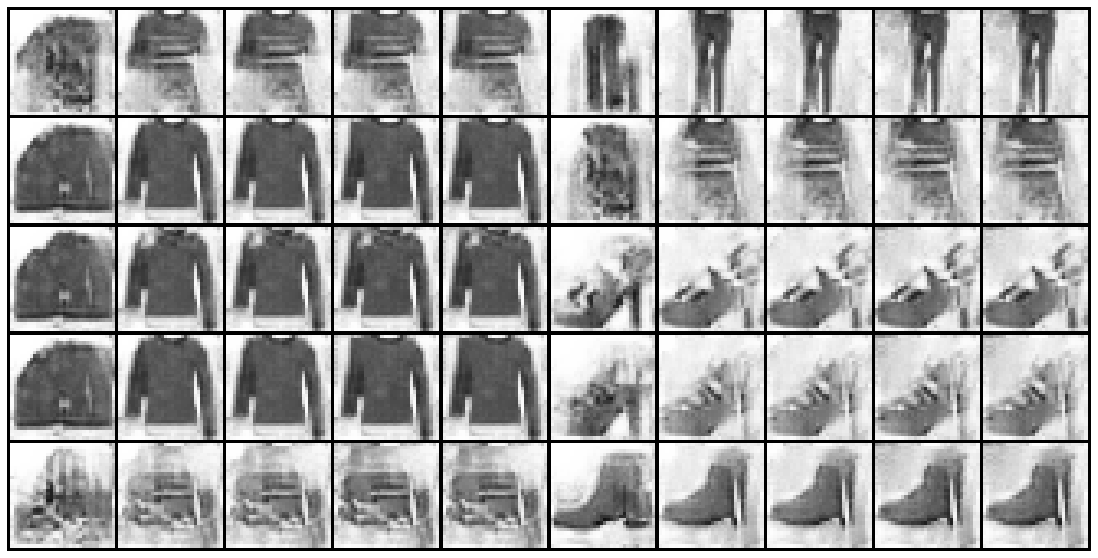

Epoch [31 / 32] G loss: 4.929405212402344 D loss: 0.07212544232606888


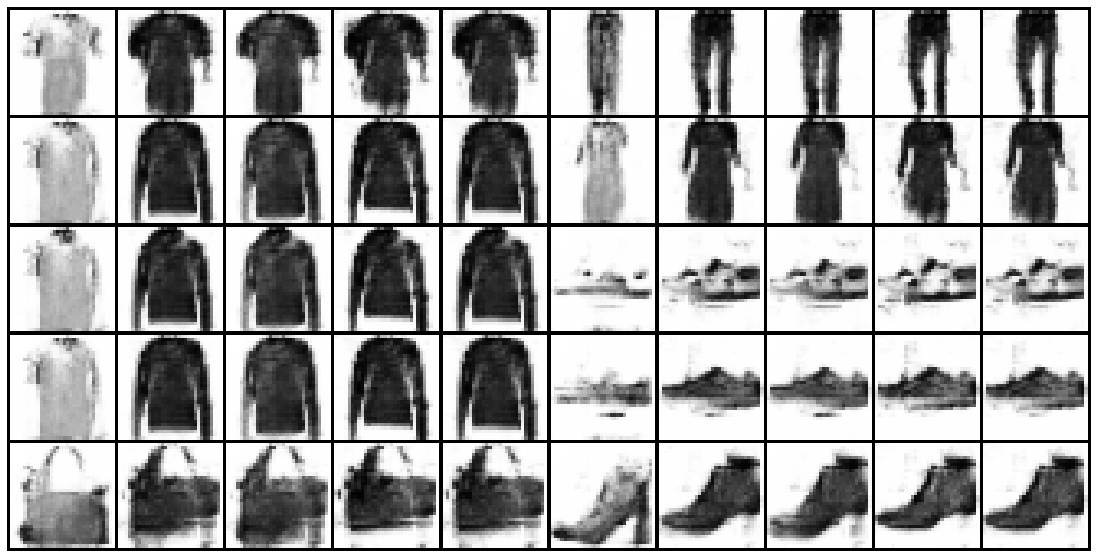

Epoch [32 / 32] G loss: 6.150174140930176 D loss: 0.043949972838163376


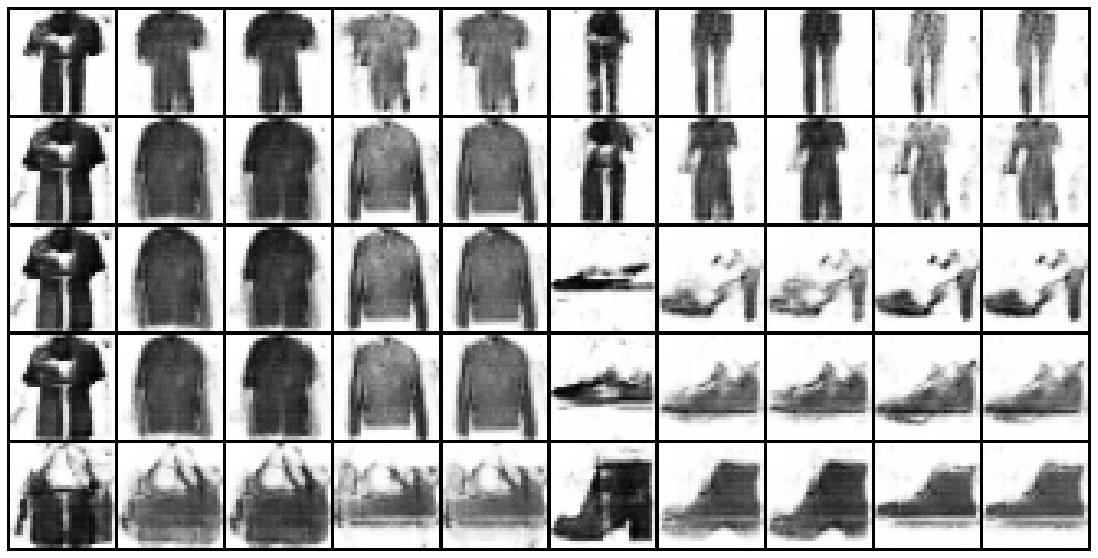

Avg per epoch time: 47.75 sec, total 32 epochs time: 25.61 min
Training finished!
...saving training results


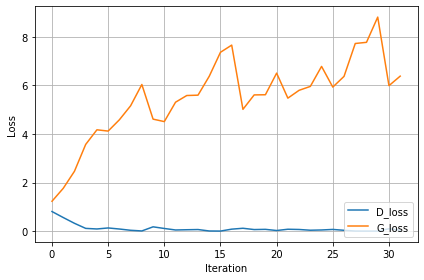

In [155]:
plt.ion()

# define dataloader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

result_dir = '{}_conditional_DCGAN'.format(dset_name)

# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
    
device = torch.device("cuda:0")

#######################################################################################################
# TODO 12: define training setup
#######################################################################################################

# TODO define networks
G = Generator(10).cuda()
D = Discriminator(10).cuda()

# TODO define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[0.5, 0.999])
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[0.5, 0.999])

progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    num_batches = 0
    
    for real, real_labels in data_loader:
        
        #######################################################################################################
        # TODO 13: Fill code for training loop
        #######################################################################################################
        
        batch_size = real.size()[0]
        real = real.cuda()
        real_labels = real_labels.cuda()
        # generate random latent vector z and random class assignments for each generated image in the minibatch as well as real and fake labels 
    
        z =  torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 100))).float().cuda()
        fake_labels = torch.randint(low=0, high=10, size=(batch_size, 1)).cuda()
        
        # generate fakes    

        fake = G(z, fake_labels)
        
        # evaluate fakes
        
        fake_evals = D(fake, fake_labels)

        # evaluate real minibatch
         
        real_evals = D(real, real_labels)
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        
        D_train_loss = loss_function(fake_evals, torch.zeros(batch_size, 1).cuda()) + loss_function(real_evals, torch.ones(batch_size, 1).cuda())

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward(retain_graph=True)
        D_optimizer.step() 
        
        # train generator to output an image that is classified as real              
        G_train_loss = loss_function(fake_evals, torch.ones(batch_size, 1).cuda())     
        
        # train generator G step
        G.zero_grad()
        D.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())
        
        epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_conditional_result( epoch, save=True, show=True, path=result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)
     
end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot loss curves
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# show training progress as animation
images = []
for e in range(num_epochs):
    img_name = result_dir + '/{}_conditional_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/conditional_DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

<img src='faces_conditional_DCGAN/conditional_DCGAN_generation_animation.gif' width="1024">